In [1]:
!pip install shap lime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import joblib

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


2025-10-24 17:48:25.953785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761328106.201806      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761328106.270206      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [2]:
hotels = pd.read_csv('/kaggle/input/international-hotel-booking-analytics/hotels.csv')
reviews = pd.read_csv('/kaggle/input/international-hotel-booking-analytics/reviews.csv')
users = pd.read_csv('/kaggle/input/international-hotel-booking-analytics/users.csv')

print("hotels:", hotels.shape)
print("reviews:", reviews.shape)
print("users:", users.shape)

hotels: (25, 13)
reviews: (50000, 12)
users: (2000, 6)


In [3]:
print("\n" + "="*40)
print("HOTELS DATAFRAME INFO")
print("="*40)
hotels.info()

print("\n" + "-"*40)
print("USERS DATAFRAME INFO")
print("-"*40)
users.info()

print("\n" + "-"*40)
print("REVIEWS DATAFRAME INFO")
print("-"*40)
reviews.info()


HOTELS DATAFRAME INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              25 non-null     int64  
 1   hotel_name            25 non-null     object 
 2   city                  25 non-null     object 
 3   country               25 non-null     object 
 4   star_rating           25 non-null     int64  
 5   lat                   25 non-null     float64
 6   lon                   25 non-null     float64
 7   cleanliness_base      25 non-null     float64
 8   comfort_base          25 non-null     float64
 9   facilities_base       25 non-null     float64
 10  location_base         25 non-null     float64
 11  staff_base            25 non-null     float64
 12  value_for_money_base  25 non-null     float64
dtypes: float64(8), int64(2), object(3)
memory usage: 2.7+ KB

----------------------------------------
USERS

In [4]:
hotels.head()

hotel_id         hotel_name      city               country  star_rating  \
0         1    The Azure Tower  New York         United States            5   
1         2  The Royal Compass    London        United Kingdom            5   
2         3    L'Étoile Palace     Paris                France            5   
3         4       Kyo-to Grand     Tokyo                 Japan            5   
4         5   The Golden Oasis     Dubai  United Arab Emirates            5   

       lat       lon  cleanliness_base  comfort_base  facilities_base  \
0  40.7580  -73.9855               9.1           8.8              8.9   
1  51.5072   -0.1276               9.0           9.2              8.8   
2  48.8566    2.3522               8.8           9.4              8.7   
3  35.6895  139.6917               9.6           9.0              9.3   
4  25.2769   55.2962               9.3           9.5              9.6   

   location_base  staff_base  value_for_money_base  
0            9.5         8.6                   8.0  
1            9.4         9.0                   7.9  
2            9.6         9.3                   8.1  
3            8.5         9.5                   8.2  
4            8.9         9.4                   8.5

In [5]:
reviews.head()

review_id  user_id  hotel_id review_date  score_overall  score_cleanliness  \
0          1     1600         1  2022-10-07            8.7                8.6   
1          2      432         4  2020-03-24            9.1               10.0   
2          3      186        18  2023-12-18            8.8                9.7   
3          4     1403        19  2022-06-22            8.9                9.0   
4          5     1723        17  2022-07-02            9.1                8.9   

   score_comfort  score_facilities  score_location  score_staff  \
0            8.7               8.5             9.0          8.8   
1            9.1               9.0             8.6          9.4   
2            8.8               8.3             8.7          8.1   
3            8.8               8.5             9.6          9.1   
4            9.5               9.3             8.3          9.4   

   score_value_for_money                                        review_text  
0                    8.7  Practice reduce young our because machine. Rec...  
1                    8.6  Test cover traditional black. Process tell Mr ...  
2                    8.6  Friend million student social study yeah. Grow...  
3                    8.3  Huge girl already remain truth behind card. Ap...  
4                    8.9  Cover feeling call community serve television ...

In [6]:
users.head()

user_id user_gender         country age_group traveller_type   join_date
0        1      Female  United Kingdom     35-44           Solo  2024-09-29
1        2        Male  United Kingdom     25-34           Solo  2023-11-29
2        3      Female          Mexico     25-34         Family  2022-04-03
3        4        Male           India     35-44         Family  2023-12-02
4        5       Other           Japan     25-34           Solo  2021-12-18

# Data Cleaning, normalization

This step was performed to clean and standardize the dataset before merging and analysis. First, string columns such as country, user_gender, traveller_type, city, and hotel_name were normalized by removing any leading or trailing whitespace and ensuring consistent text formatting. This helps prevent issues like mismatched text entries (for example, “ Egypt” vs. “Egypt”) that could lead to duplicate categories or incorrect joins during merging.

Overall, this cleaning step ensures that the data is consistent, properly formatted, and ready for further preprocessing, merging, and analysis. They help maintain the integrity of the dataset and prevent errors that might occur in later stages such as feature engineering or model training.

In [7]:
def normalize_col(df, col):
    if col in df.columns and df[col].dtype == object:
        df[col] = df[col].astype(str).str.strip()
        return True
    return False

for c in ['country', 'user_gender', 'traveller_type', 'city', 'hotel_name']:
    if c in hotels.columns:
        normalize_col(hotels, c)
    if c in users.columns:
        normalize_col(users, c)
    if c in reviews.columns:
        normalize_col(reviews, c)

# Merge Dataset

In this step, the reviews, hotels, and users datasets were merged to create a single comprehensive dataframe that combines all relevant information about each review, hotel, and user.
* The datasets were merged using left joins (how='left') to ensure that all reviews remain in the final dataset, even if some hotels or users have missing details.
* The merge was performed using the common keys:
  * hotel_id to link each review to its corresponding hotel.
  * user_id to link each review to the user who wrote it.
* The suffixes parameter (('', '_hotel') and ('', '_user')) was used to differentiate columns with the same names across datasets, ensuring that no data is overwritten.

After merging, the resulting dataframe df contains all the combined information, which can now be used for further analysis and model training.

In [8]:
df = reviews.merge(hotels, on='hotel_id', how='left', suffixes=('', '_hotel'))
df = df.merge(users, on='user_id', how='left', suffixes=('', '_user'))

print("\nMerged dataset shape:", df.shape)
print("\nMerged columns (first 40):\n", df.columns.tolist()[:40])

df.head()


Merged dataset shape: (50000, 29)

Merged columns (first 40):
 ['review_id', 'user_id', 'hotel_id', 'review_date', 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'review_text', 'hotel_name', 'city', 'country', 'star_rating', 'lat', 'lon', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'user_gender', 'country_user', 'age_group', 'traveller_type', 'join_date']


review_id  user_id  hotel_id review_date  score_overall  score_cleanliness  \
0          1     1600         1  2022-10-07            8.7                8.6   
1          2      432         4  2020-03-24            9.1               10.0   
2          3      186        18  2023-12-18            8.8                9.7   
3          4     1403        19  2022-06-22            8.9                9.0   
4          5     1723        17  2022-07-02            9.1                8.9   

   score_comfort  score_facilities  score_location  score_staff  \
0            8.7               8.5             9.0          8.8   
1            9.1               9.0             8.6          9.4   
2            8.8               8.3             8.7          8.1   
3            8.8               8.5             9.6          9.1   
4            9.5               9.3             8.3          9.4   

   score_value_for_money                                        review_text  \
0                    8.7  Practice reduce young our because machine. Rec...   
1                    8.6  Test cover traditional black. Process tell Mr ...   
2                    8.6  Friend million student social study yeah. Grow...   
3                    8.3  Huge girl already remain truth behind card. Ap...   
4                    8.9  Cover feeling call community serve television ...   

        hotel_name       city        country  star_rating      lat       lon  \
0  The Azure Tower   New York  United States            5  40.7580  -73.9855   
1     Kyo-to Grand      Tokyo          Japan            5  35.6895  139.6917   
2    Nile Grandeur      Cairo          Egypt            5  30.0444   31.2357   
3  Gaudi's Retreat  Barcelona          Spain            5  41.3851    2.1734   
4   Kremlin Suites     Moscow         Russia            5  55.7558   37.6173   

   cleanliness_base  comfort_base  facilities_base  location_base  staff_base  \
0               9.1           8.8              8.9            9.5         8.6   
1               9.6           9.0              9.3            8.5         9.5   
2               8.8           8.7              8.6            9.1         8.7   
3               9.2           9.1              8.9            9.7         9.0   
4               9.1           9.3              9.0            9.0         9.1   

   value_for_money_base user_gender    country_user age_group traveller_type  \
0                   8.0      Female     New Zealand     25-34           Solo   
1                   8.2      Female  United Kingdom     35-44         Couple   
2                   8.4      Female           Spain       55+         Couple   
3                   8.8      Female  United Kingdom     35-44       Business   
4                   8.6        Male       Australia     45-54         Family   

    join_date  
0  2021-03-21  
1  2025-04-01  
2  2021-10-28  
3  2023-10-10  
4  2023-02-28

In [9]:
df['user_gender'] = df['user_gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
df['age_group'] = df['age_group'].map({'35-44': 0, '25-34': 1, '45-54': 2 , '18-24': 3, '55+': 4})
df['traveller_type'] = df['traveller_type'].map({'Solo': 0, 'Family': 1, 'Couple': 2 , 'Business': 3})

In [10]:
df.head()

review_id  user_id  hotel_id review_date  score_overall  score_cleanliness  \
0          1     1600         1  2022-10-07            8.7                8.6   
1          2      432         4  2020-03-24            9.1               10.0   
2          3      186        18  2023-12-18            8.8                9.7   
3          4     1403        19  2022-06-22            8.9                9.0   
4          5     1723        17  2022-07-02            9.1                8.9   

   score_comfort  score_facilities  score_location  score_staff  \
0            8.7               8.5             9.0          8.8   
1            9.1               9.0             8.6          9.4   
2            8.8               8.3             8.7          8.1   
3            8.8               8.5             9.6          9.1   
4            9.5               9.3             8.3          9.4   

   score_value_for_money                                        review_text  \
0                    8.7  Practice reduce young our because machine. Rec...   
1                    8.6  Test cover traditional black. Process tell Mr ...   
2                    8.6  Friend million student social study yeah. Grow...   
3                    8.3  Huge girl already remain truth behind card. Ap...   
4                    8.9  Cover feeling call community serve television ...   

        hotel_name       city        country  star_rating      lat       lon  \
0  The Azure Tower   New York  United States            5  40.7580  -73.9855   
1     Kyo-to Grand      Tokyo          Japan            5  35.6895  139.6917   
2    Nile Grandeur      Cairo          Egypt            5  30.0444   31.2357   
3  Gaudi's Retreat  Barcelona          Spain            5  41.3851    2.1734   
4   Kremlin Suites     Moscow         Russia            5  55.7558   37.6173   

   cleanliness_base  comfort_base  facilities_base  location_base  staff_base  \
0               9.1           8.8              8.9            9.5         8.6   
1               9.6           9.0              9.3            8.5         9.5   
2               8.8           8.7              8.6            9.1         8.7   
3               9.2           9.1              8.9            9.7         9.0   
4               9.1           9.3              9.0            9.0         9.1   

   value_for_money_base  user_gender    country_user  age_group  \
0                   8.0            1     New Zealand          1   
1                   8.2            1  United Kingdom          0   
2                   8.4            1           Spain          4   
3                   8.8            1  United Kingdom          0   
4                   8.6            0       Australia          2   

   traveller_type   join_date  
0               0  2021-03-21  
1               2  2025-04-01  
2               2  2021-10-28  
3               3  2023-10-10  
4               1  2023-02-28

In [11]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              50000 non-null  int64  
 1   user_id                50000 non-null  int64  
 2   hotel_id               50000 non-null  int64  
 3   review_date            50000 non-null  object 
 4   score_overall          50000 non-null  float64
 5   score_cleanliness      50000 non-null  float64
 6   score_comfort          50000 non-null  float64
 7   score_facilities       50000 non-null  float64
 8   score_location         50000 non-null  float64
 9   score_staff            50000 non-null  float64
 10  score_value_for_money  50000 non-null  float64
 11  review_text            50000 non-null  object 
 12  hotel_name             50000 non-null  object 
 13  city                   50000 non-null  object 
 14  country                50000 non-null  object 
 15  st

review_id       user_id      hotel_id  score_overall  \
count  50000.000000  50000.000000  50000.000000   50000.000000   
mean   25000.500000   1005.567540     13.051100       8.943460   
std    14433.901067    576.711855      7.203808       0.180878   
min        1.000000      1.000000      1.000000       8.200000   
25%    12500.750000    507.000000      7.000000       8.800000   
50%    25000.500000   1010.000000     13.000000       8.900000   
75%    37500.250000   1504.000000     19.000000       9.100000   
max    50000.000000   2000.000000     25.000000       9.600000   

       score_cleanliness  score_comfort  score_facilities  score_location  \
count       50000.000000   50000.000000      50000.000000    50000.000000   
mean            9.052558       9.024404          8.743062        9.176410   
std             0.504296       0.423927          0.498320        0.421086   
min             7.700000       7.900000          7.600000        7.900000   
25%             8.700000       8.700000          8.400000        8.900000   
50%             9.100000       9.000000          8.700000        9.200000   
75%             9.400000       9.300000          9.100000        9.500000   
max            10.000000      10.000000         10.000000       10.000000   

        score_staff  score_value_for_money  star_rating           lat  \
count  50000.000000           50000.000000      50000.0  50000.000000   
mean       8.972076               8.434540          5.0     20.882112   
std        0.397775               0.529321          0.0     30.437484   
min        7.900000               6.800000          5.0    -41.286500   
25%        8.700000               8.100000          5.0      6.524400   
50%        9.000000               8.500000          5.0     31.230400   
75%        9.200000               8.800000          5.0     41.902800   
max       10.000000               9.700000          5.0     55.755800   

                lon  cleanliness_base  comfort_base  facilities_base  \
count  50000.000000      50000.000000  50000.000000     50000.000000   
mean      34.468497          9.091592      9.063918         8.917196   
std       73.576721          0.226334      0.234129         0.286064   
min      -99.133200          8.700000      8.600000         8.500000   
25%        2.173400          8.900000      8.900000         8.700000   
50%       18.424100          9.100000      9.100000         8.900000   
75%      100.501800          9.300000      9.200000         9.100000   
max      174.776200          9.600000      9.500000         9.600000   

       location_base    staff_base  value_for_money_base   user_gender  \
count   50000.000000  50000.000000          50000.000000  50000.000000   
mean        9.270406      9.015730              8.513232      0.621620   
std         0.347649      0.236695              0.258259      0.650889   
min         8.500000      8.600000              7.900000      0.000000   
25%         9.000000      8.800000              8.400000      0.000000   
50%         9.300000      9.000000              8.500000      1.000000   
75%         9.600000      9.200000              8.700000      1.000000   
max         9.800000      9.500000              8.900000      2.000000   

          age_group  traveller_type  
count  50000.000000    50000.000000  
mean       1.363260        1.550760  
std        1.290138        1.039252  
min        0.000000        0.000000  
25%        0.000000        1.000000  
50%        1.000000        2.000000  
75%        2.000000        2.000000  
max        4.000000        3.000000

# Graphs

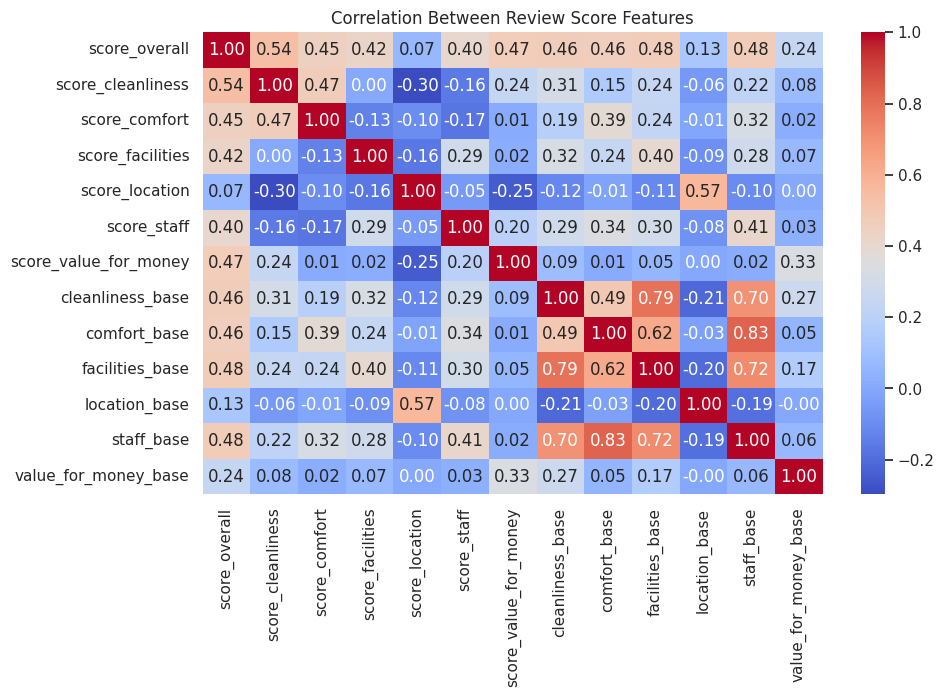

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

score_features = [
    'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'cleanliness_base', 
    'comfort_base', 
    'facilities_base', 
    'location_base', 
    'staff_base', 
    'value_for_money_base',
    
]

plt.figure(figsize=(10,6))
sns.heatmap(df[score_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Review Score Features')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


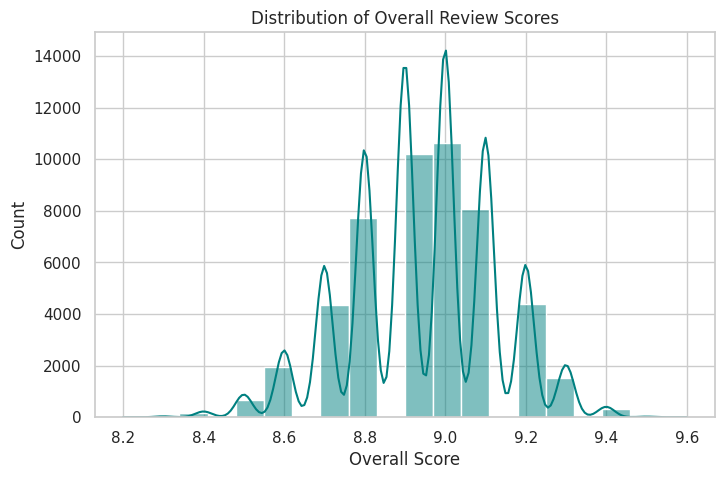

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['score_overall'], kde=True, bins=20, color='teal')
plt.title('Distribution of Overall Review Scores')
plt.xlabel('Overall Score')
plt.ylabel('Count')
plt.show()

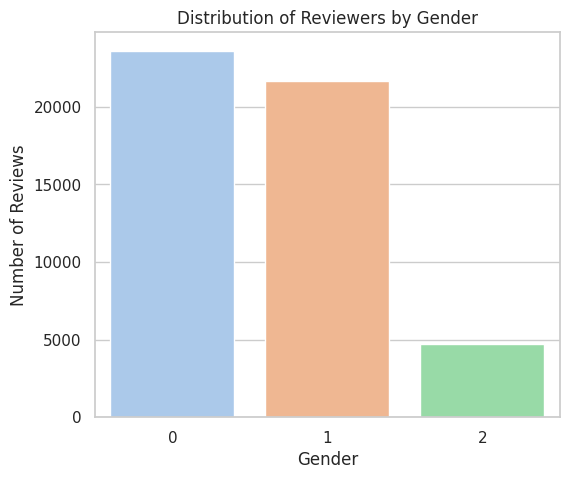

In [14]:
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='user_gender', palette='pastel')
plt.title('Distribution of Reviewers by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Reviews')
plt.show()

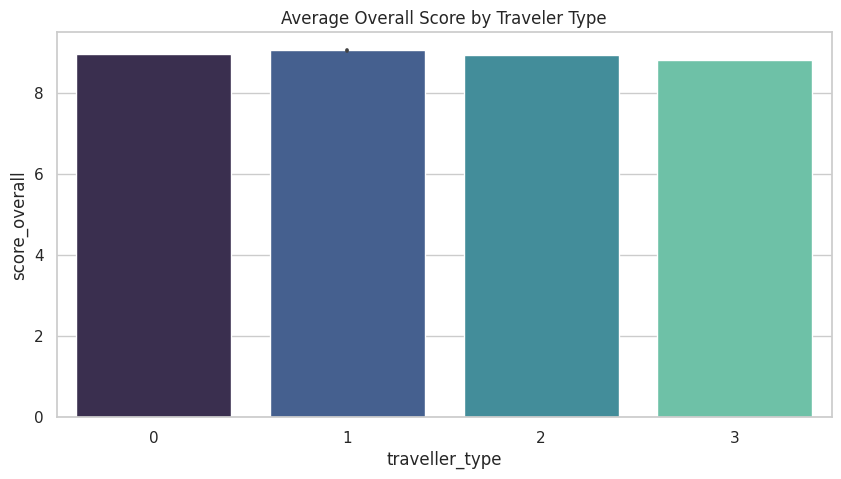

In [15]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='traveller_type', y='score_overall', palette='mako')
plt.title('Average Overall Score by Traveler Type')
plt.xticks()
plt.show()

# Data-Engineering Questions 

Which city is best for each traveler type? For each traveler type, 
recommend the best city based on the given reviews. 

In this section, we analyze which cities perform best for each traveler type based on their average overall review scores.


* The dataset is grouped by traveler type and city, calculating:

  * The average overall score for each combination.

  * The number of reviews per group (to measure data reliability).

* Cities with fewer than 20 reviews are filtered out to ensure that the results are based on a sufficient amount of feedback.

* For each traveler type, the city with the highest average score is selected as the best city.

* To provide a broader view, the top 3 cities per traveler type are also displayed in a bar plot for comparison.

* The visualization helps identify which destinations different types of travelers rate most highly, offering insights into travel preferences and satisfaction patterns across cities.

Best city per traveler type based on average overall score:


traveller_type       city  avg_overall  num_reviews
0           Solo  Amsterdam     9.108454          414
1         Family      Dubai     9.214381          452
2         Couple  Amsterdam     9.096989          631
3       Business      Dubai     8.965668          434

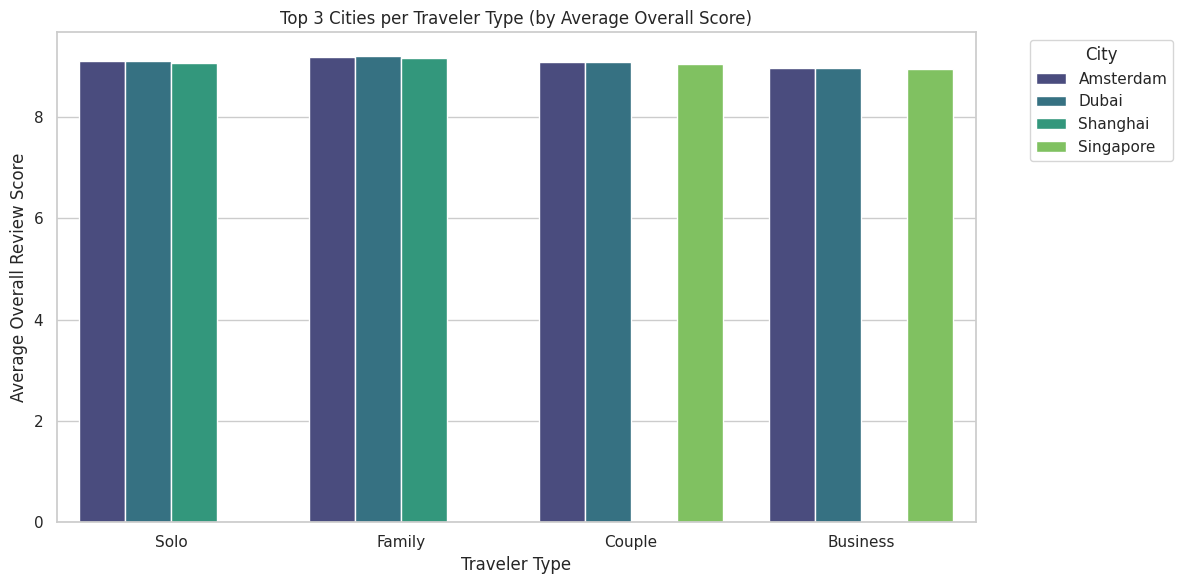

In [16]:
traveller_type_map = {0: 'Solo', 1: 'Family', 2: 'Couple', 3: 'Business'}

city_by_type = (
    df.groupby(['traveller_type', 'city'])
      .agg(avg_overall=('score_overall', 'mean'),
           num_reviews=('score_overall', 'count'))
      .reset_index()
)

min_reviews = 20
city_by_type = city_by_type[city_by_type['num_reviews'] >= min_reviews]


best_city_each_type = (
    city_by_type
    .sort_values(['traveller_type', 'avg_overall'], ascending=[True, False])
    .groupby('traveller_type')
    .first()
    .reset_index()
)

best_city_each_type['traveller_type'] = best_city_each_type['traveller_type'].map(traveller_type_map)

print("Best city per traveler type based on average overall score:")
display(best_city_each_type)

top3_cities = (
    city_by_type
    .sort_values(['traveller_type', 'avg_overall'], ascending=[True, False])
    .groupby('traveller_type')
    .head(3)
)

top3_cities['traveller_type'] = top3_cities['traveller_type'].map(traveller_type_map)


plt.figure(figsize=(12,6))
sns.barplot(data=top3_cities, x='traveller_type', y='avg_overall', hue='city', palette='viridis')
plt.title('Top 3 Cities per Traveler Type (by Average Overall Score)')
plt.ylabel('Average Overall Review Score')
plt.xlabel('Traveler Type')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


What are the top 3 countries with the best value-for-money score per 
traveler’s age group? 

In this section, we explore which countries offer the best value for money according to different age groups of travelers.

* The dataset is grouped by traveler age group and country, and two key statistics are calculated:

    * The average value for money (VFM) score, representing how travelers perceive the worth of their stay relative to cost.

    * The number of reviews, ensuring sufficient data representation for each group.

* For each age group, the top three countries with the highest average VFM scores are selected.

* The results are visualized using a bar plot, making it easy to compare which countries are most appreciated for their value across different age demographics.

* This analysis highlights how travel preferences and price sensitivity vary with age, helping travel platforms or hotel businesses better tailor their pricing and marketing strategies for specific age groups.

Top 3 countries per age group by value-for-money score:


age_group      country   avg_vfm  num_reviews
4       35-44        China  8.700799          626
12      35-44  Netherlands  8.693268          609
13      35-44  New Zealand  8.646429          672
29      25-34        China  8.727941          680
37      25-34  Netherlands  8.683442          616
44      25-34        Spain  8.625074          674
54      45-54        China  8.722112          303
63      45-54  New Zealand  8.674194          310
62      45-54  Netherlands  8.647458          295
79      18-24        China  8.706926          231
87      18-24  Netherlands  8.704911          224
78      18-24       Canada  8.661261          222
112       55+  Netherlands  8.698537          205
113       55+  New Zealand  8.629384          211
104       55+        China  8.601000          200

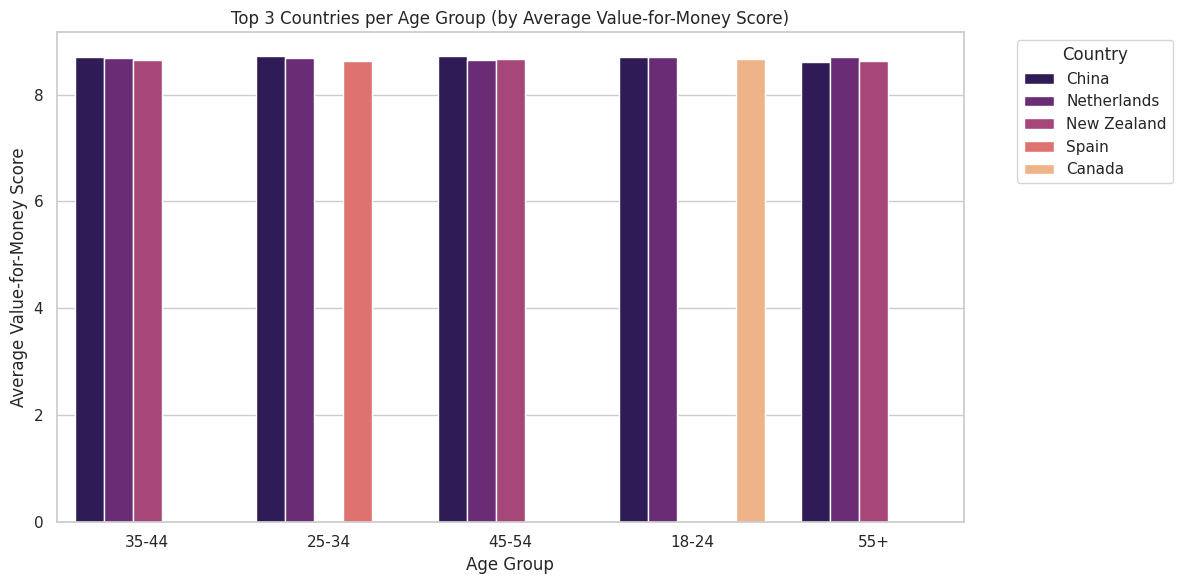

In [17]:
age_group_map = {
    0: '35-44',
    1: '25-34',
    2: '45-54',
    3: '18-24',
    4: '55+'
}
vfm_by_age_country = (
    df.groupby(['age_group', 'country'])
      .agg(
          avg_vfm=('score_value_for_money', 'mean'),
          num_reviews=('score_value_for_money', 'count')
      )
      .reset_index()
)

min_reviews = 20
vfm_by_age_country = vfm_by_age_country[vfm_by_age_country['num_reviews'] >= min_reviews]

top3_vfm = (
    vfm_by_age_country
    .sort_values(['age_group', 'avg_vfm'], ascending=[True, False])
    .groupby('age_group')
    .head(3)
)

top3_vfm['age_group'] = top3_vfm['age_group'].map(age_group_map)

print("Top 3 countries per age group by value-for-money score:")
display(top3_vfm)


plt.figure(figsize=(12,6))
sns.barplot(data=top3_vfm, x='age_group', y='avg_vfm', hue='country', palette='magma')
plt.title('Top 3 Countries per Age Group (by Average Value-for-Money Score)')
plt.ylabel('Average Value-for-Money Score')
plt.xlabel('Age Group')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Country Column

In [18]:
country_to_group = {
    # North America
    'united states': 'North_America',
    'united states of america': 'North_America',
    'usa': 'North_America',
    'canada': 'North_America',

    # Western Europe
    'germany': 'Western_Europe',
    'france': 'Western_Europe',
    'united kingdom': 'Western_Europe',
    'uk': 'Western_Europe',
    'netherlands': 'Western_Europe',
    'spain': 'Western_Europe',
    'italy': 'Western_Europe',

    # Eastern Europe
    'russia': 'Eastern_Europe',

    # East Asia
    'china': 'East_Asia',
    'japan': 'East_Asia',
    'south korea': 'East_Asia',
    'korea, south': 'East_Asia',

    # Southeast Asia
    'thailand': 'Southeast_Asia',
    'singapore': 'Southeast_Asia',

    # Middle East
    'united arab emirates': 'Middle_East',
    'uae': 'Middle_East',
    'turkey': 'Middle_East',

    # Africa
    'egypt': 'Africa',
    'nigeria': 'Africa',
    'south africa': 'Africa',

    # Oceania
    'australia': 'Oceania',
    'new zealand': 'Oceania',

    # South America
    'brazil': 'South_America',
    'argentina': 'South_America',

    # South Asia
    'india': 'South_Asia',

    # North America - Mexico
    'mexico': 'North_America_Mexico'
}


In [19]:
df['country'] = df['country'].astype(str).str.strip().str.lower()

def map_country_to_group(country):
    if country in country_to_group:
        return country_to_group[country]
    else:
        return 'Other'

df['country_group'] = df['country'].apply(map_country_to_group)

print("country_group column created successfully!\n")
print(df['country_group'].value_counts(dropna=False))


country_group column created successfully!

country_group
Western_Europe          11876
Africa                   6132
East_Asia                6082
Southeast_Asia           4070
Oceania                  4014
Middle_East              3983
North_America            3962
South_America            3918
North_America_Mexico     2004
South_Asia               1989
Eastern_Europe           1970
Name: count, dtype: int64


Label Encoding for country_group column

most machine learning models can only work with numerical inputs and outputs, not text or categorical strings.

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = df['country_group']
y_encoded = le.fit_transform(y)

mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping (class → number):")
print(mapping)


Label mapping (class → number):
{'Africa': 0, 'East_Asia': 1, 'Eastern_Europe': 2, 'Middle_East': 3, 'North_America': 4, 'North_America_Mexico': 5, 'Oceania': 6, 'South_America': 7, 'South_Asia': 8, 'Southeast_Asia': 9, 'Western_Europe': 10}


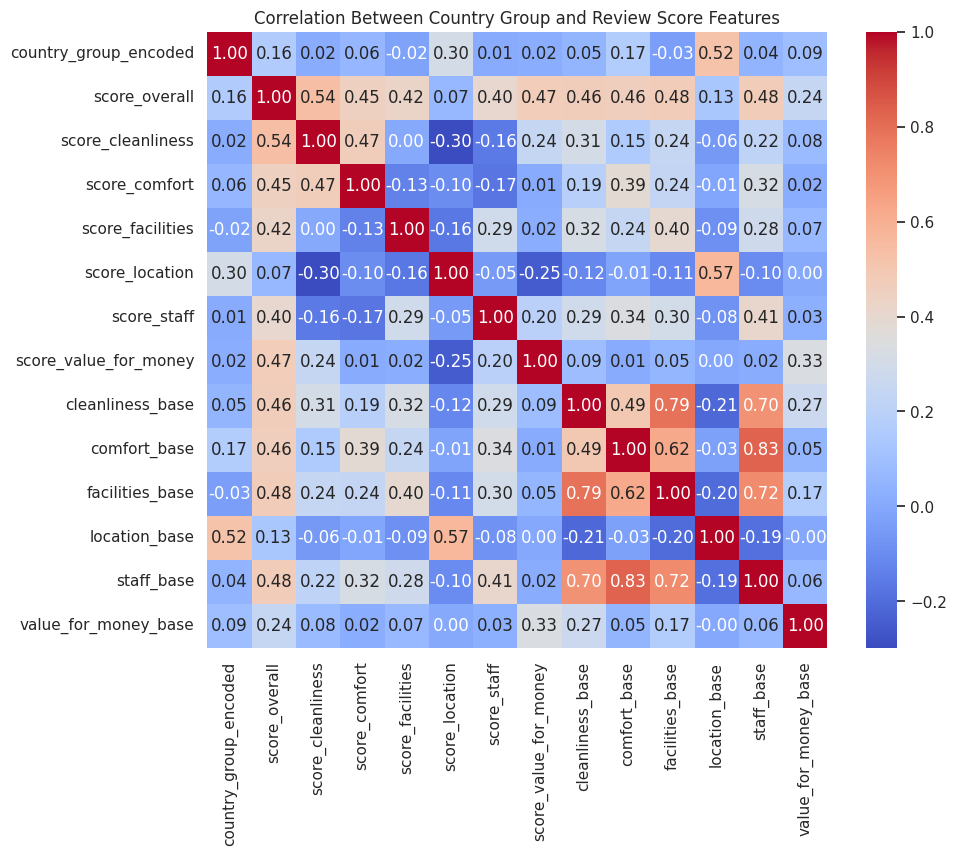

In [21]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df_encoded = df.copy()

le = LabelEncoder()
df_encoded['country_group_encoded'] = le.fit_transform(df_encoded['country_group'])

cols_for_corr = [
    'country_group_encoded',
    'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'cleanliness_base', 
    'comfort_base', 
    'facilities_base', 
    'location_base', 
    'staff_base', 
    'value_for_money_base'
]

# Compute correlation
corr_matrix = df_encoded[cols_for_corr].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Country Group and Review Score Features')
plt.show()


# ALL FEATURES

First , for predicting the country group, we tried selecting a balanced set of score-based and user-related features that capture both hotel quality and reviewer behavior. The score-based features include user ratings and hotel baseline ratings, allowing the model to learn satisfaction patterns relative to each hotel’s typical performance. User features (age_group, traveller_type, user_gender) represent demographic and behavioral factors influencing review tendencies. We excluded identifiers (hotel_id, review_id, user_id) and geographic fields (city, country, lat, lon) to avoid data leakage and overfitting. This final feature set provides interpretable, generalizable insights into how user demographics and review patterns vary across regions, enabling the model to predict country groups based on consistent rating behavior rather than explicit location data.

In [22]:
score_features = [
   'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'cleanliness_base', 
    'comfort_base', 
    'facilities_base', 
    'location_base', 
    'staff_base', 
    'value_for_money_base'
]

user_features = ['age_group', 'traveller_type', 'user_gender']


X_All = df[score_features + user_features]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_All, y_encoded, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression

To evaluate a simpler and more interpretable approach, we trained a Multinomial Logistic Regression model using the same selected feature set. Logistic Regression is effective for multi-class classification and provides insight into how each feature influences the probability of belonging to a specific country group. We set multi_class='multinomial' and increased the maximum iterations to ensure proper convergence on our multi-class dataset.

After training on X_train and evaluating on X_test, we computed the accuracy, precision, recall, and F1-score using weighted averages to account for class imbalance across country groups. The classification report and confusion matrix visualize the model’s performance, highlighting which country groups are most or least accurately predicted. Finally, we plotted the evaluation metrics for a clearer comparison. This step helps benchmark the performance of a simple linear model before moving to more complex algorithms like Random Forest or Neural Networks.

In [24]:
from sklearn.linear_model import LogisticRegression

model_Log1 = LogisticRegression(max_iter=1000, multi_class='multinomial')
model_Log1.fit(X_train, y_train)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = model_Log1.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7926
Precision: 0.7259250852776511
Recall: 0.7926
F1 Score: 0.7520684406812691

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1226
           1       0.86      0.93      0.89      1216
           2       1.00      1.00      1.00       394
           3       0.72      0.53      0.61       797
           4       0.91      1.00      0.95       792
           5       1.00      1.00      1.00       401
           6       0.08      0.02      0.03       803
           7       1.00      1.00      1.00       784
           8       0.00      0.00      0.00       398
           9       0.98      1.00      0.99       814
          10       0.68      0.90      0.78      2375

    accuracy                           0.79     10000
   macro avg       0.72      0.75      0.73     10000
weighted avg       0.73      0.79      0.75     10000


Confusion Matrix:
[[1039    0    0    0    0    0    0    0    0    0  

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


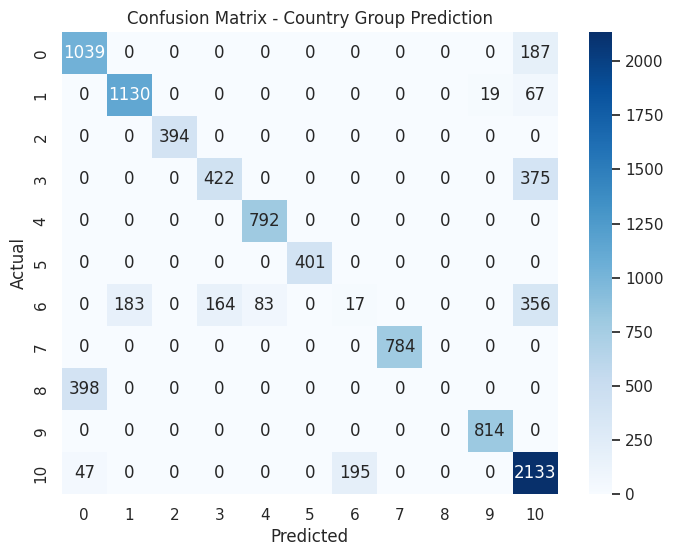

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=model_Log1.classes_,
            yticklabels=model_Log1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Country Group Prediction')
plt.show()


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


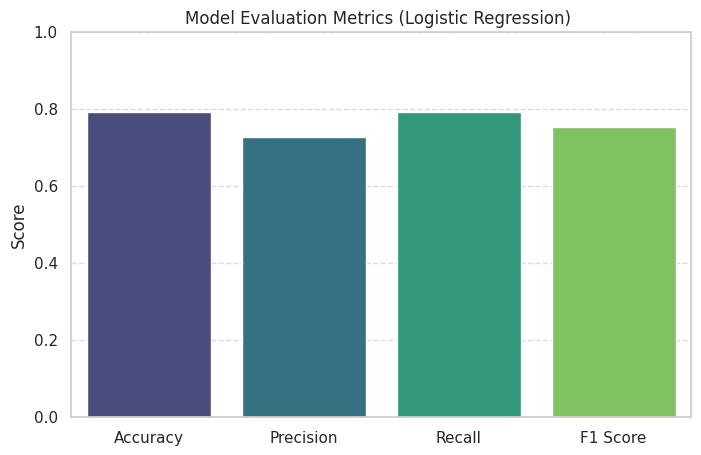

In [27]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}

import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Logistic Regression) ')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Random Forest

To improve prediction accuracy and capture non-linear relationships in the data, we trained a Random Forest Classifier using the same features and target variable. It reduces overfitting compared to a single tree and performs well with both numerical and categorical features.

We used 200 trees (n_estimators=200), limited their depth to 10 (max_depth=10) to prevent overfitting, and required at least 5 samples to split a node (min_samples_split=5) for stability. The model was evaluated on the test set using accuracy, precision, recall, and F1-score, summarized through a classification report and a confusion matrix. Finally, the evaluation metrics were visualized using a bar chart for easy comparison with the Logistic Regression model.

This model captures complex interactions between review scores and user characteristics, providing a stronger baseline for multi-class country group prediction.

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_model1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,          
    min_samples_split=5,   
    random_state=42
)

rf_model1.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = rf_model1.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1226
           1       1.00      1.00      1.00      1216
           2       1.00      1.00      1.00       394
           3       1.00      1.00      1.00       797
           4       1.00      1.00      1.00       792
           5       1.00      1.00      1.00       401
           6       1.00      1.00      1.00       803
           7       1.00      1.00      1.00       784
           8       1.00      1.00      1.00       398
           9       1.00      1.00      1.00       814
          10       1.00      1.00      1.00      2375

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


Confusion Matrix:
[[1226    0    0    0    0    0    0    0    0    0    0]
 [   0 1216    0    0    0    0

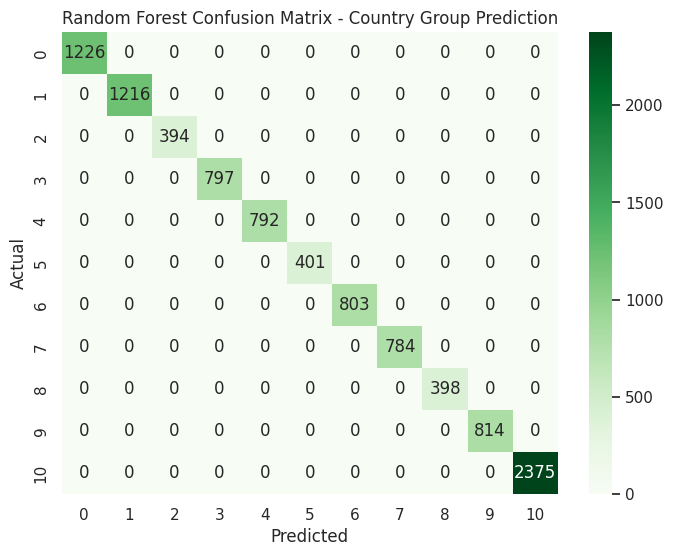

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens',
            xticklabels=rf_model1.classes_,
            yticklabels=rf_model1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix - Country Group Prediction')
plt.show()


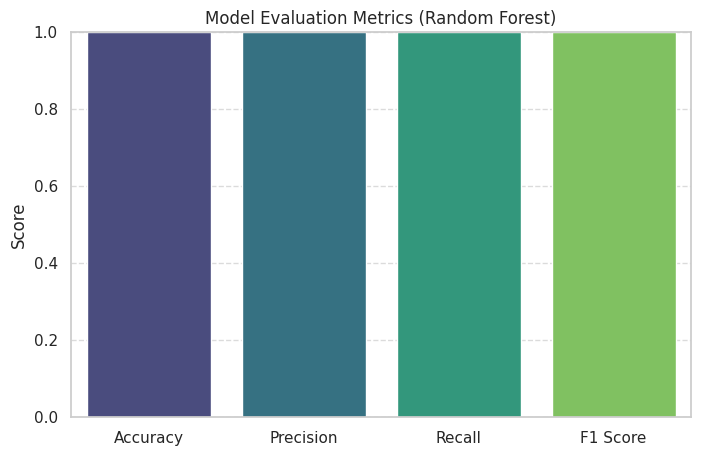

In [31]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}

import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])


plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Random Forest)')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Neural Network

To explore a more flexible non-linear model, we developed a Feedforward Neural Network (FFNN) for multi-class country group prediction. The target variable was label-encoded and then one-hot encoded to match the softmax output structure, while all input features were standardized using StandardScaler to ensure uniform feature scaling.

The FFNN architecture consists of an input layer, two hidden layers (16 and 8 neurons) with ReLU activation for non-linearity, and a softmax output layer with one neuron per country group. The model was compiled using the Adam optimizer and categorical crossentropy loss, with accuracy, precision, and recall as performance metrics.

Training was performed for 20 epochs with an 80/20 validation split, and the results were visualized to monitor accuracy, precision, and recall trends across epochs. After training, predictions on the test set were evaluated using accuracy, precision, recall, and F1-score, along with a confusion matrix for class-level performance insights.

This FFNN captures complex, non-linear relationships between user demographics and hotel review patterns, often outperforming simpler models like Logistic Regression when sufficient data and feature diversity are present.

2025-10-24 17:49:30.902007: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507 (1.98 KB)

 Trainable params: 507 (1.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3910 - loss: 1.8085 - precision: 0.8007 - recall: 0.1476 - val_accuracy: 0.8364 - val_loss: 0.6279 - val_precision: 0.9548 - val_recall: 0.6601
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8995 - loss: 0.4039 - precision: 0.9656 - recall: 0.8004 - val_accuracy: 0.9995 - val_loss: 0.0819 - val_precision: 1.0000 - val_recall: 0.9985
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0560 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0163 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0122 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0051 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0041 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - va

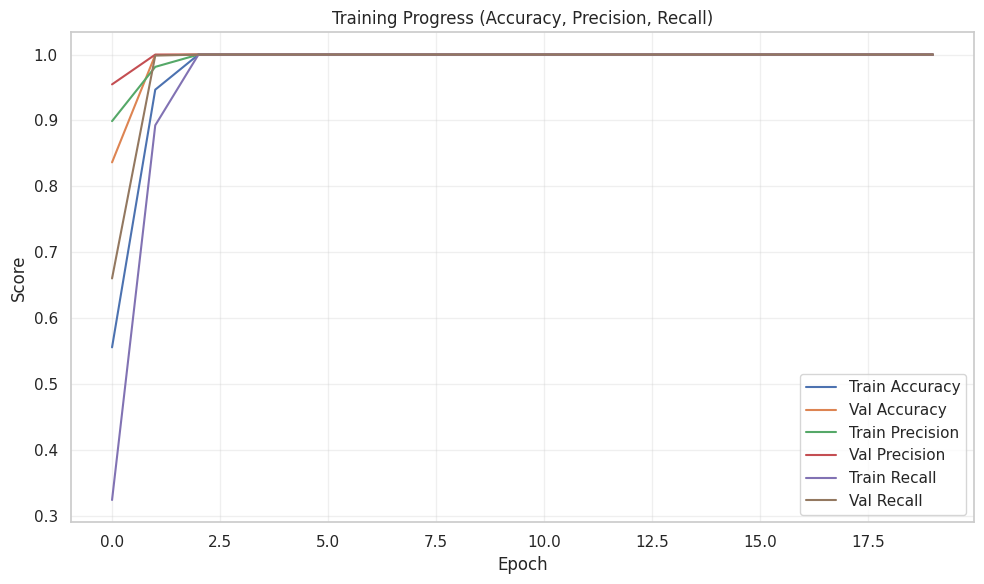

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
                      precision    recall  f1-score   support

              Africa       1.00      1.00      1.00      1226
           East_Asia       1.00      1.00      1.00      1216
      Eastern_Europe       1.00      1.00      1.00       394
         Middle_East       1.00      1.00      1.00       797
       North_America       1.00      1.00      1.00       792
North_America_Mexico       1.00      1.00      1.00       401
             Oceania       1.00      1.00      1.00       803
       South_America       1.00      1.00      1.00       784
          South_Asia       1.00      1.00      1.00       398
      Southeast_Asia       1.00      1.00      1.00       814
      Western_Europe       1.00      1.00      1.00      2375

            accuracy                           1.00     10000
           macro avg       1.00      1.00      1.00     10000
        we

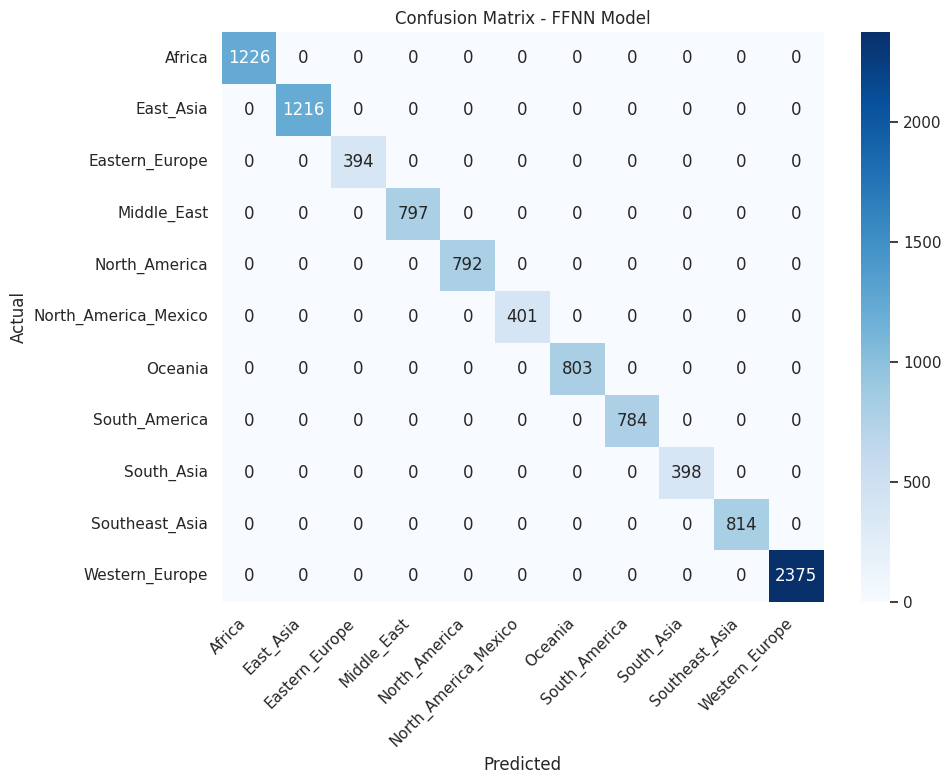

In [32]:
le = LabelEncoder()
y_encoded = le.fit_transform(df['country_group'])
y_categorical = to_categorical(y_encoded)  # one-hot encode for softmax output

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_All)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_categorical,
    test_size=0.2, random_state=42,
    stratify=y_categorical
)

ffnn_model1 = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(y_categorical.shape[1], activation='softmax')  # output neurons = num of classes
])

ffnn_model1.summary()

ffnn_model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history = ffnn_model1.fit(
    X_train_scaled, y_train_scaled,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')

plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Progress (Accuracy, Precision, Recall)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

y_pred_probs_ffnn = ffnn_model1.predict(X_test_scaled)
y_pred_ffnn = np.argmax(y_pred_probs_ffnn, axis=1)
y_true_ffnn = np.argmax(y_test_scaled, axis=1)

print("Accuracy:", accuracy_score(y_true_ffnn, y_pred_ffnn))
print("Precision:", precision_score(y_true_ffnn, y_pred_ffnn, average='weighted'))
print("Recall:", recall_score(y_true_ffnn, y_pred_ffnn, average='weighted'))
print("F1 Score:", f1_score(y_true_ffnn, y_pred_ffnn, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_true_ffnn, y_pred_ffnn, target_names=le.classes_))

cm = confusion_matrix(y_true_ffnn, y_pred_ffnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - FFNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Comparing the models

After training three models, we compared their predictive performance using consistent evaluation metrics: accuracy, precision, recall, and F1-score.

Predictions were generated for each model on the same test set, and all metrics were computed using weighted averages to account for any class imbalance across country groups. The results were then compiled into a unified dataframe and visualized through a grouped bar chart for direct comparison.

This visualization highlights the relative strengths of each model:

Logistic Regression provides a simple linear baseline.

Random Forest captures complex non-linear feature interactions, typically improving accuracy.

FFNN models deeper, multi-dimensional relationships between user demographics and review patterns.

By comparing their scores side-by-side, we can assess trade-offs between interpretability (Logistic Regression), robustness (Random Forest), and expressive power (FFNN), helping identify which model best generalizes for multi-class country group prediction.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


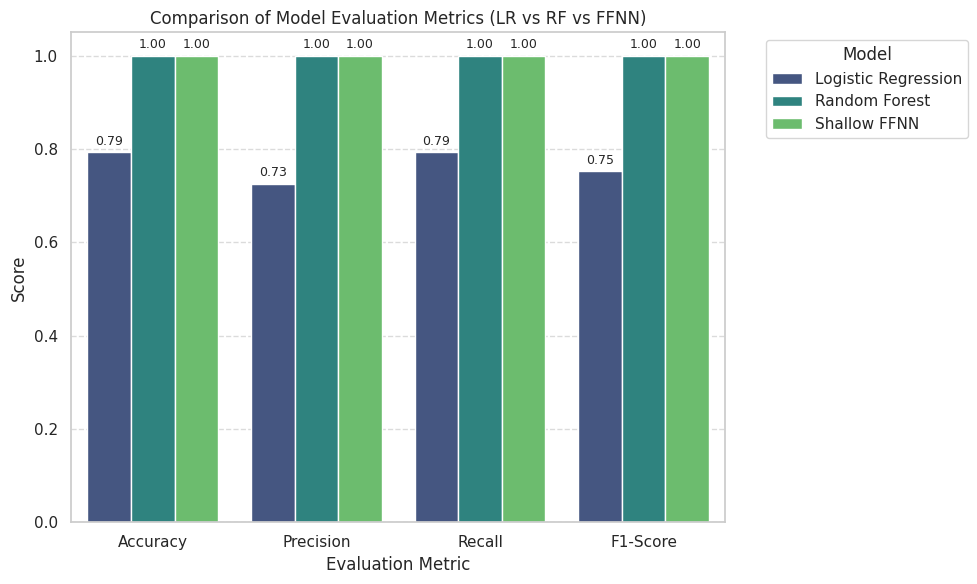


📊 Model Performance Summary:



Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.7926     0.7259  0.7926    0.7521
1        Random Forest    1.0000     1.0000  1.0000    1.0000
2         Shallow FFNN    1.0000     1.0000  1.0000    1.0000

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_lr = model_Log1.predict(X_test)

y_pred_rf = rf_model1.predict(X_test)

y_pred_probs_ffnn = ffnn_model1.predict(X_test_scaled)
y_pred_ffnn = np.argmax(y_pred_probs_ffnn, axis=1)
y_true_ffnn = np.argmax(y_test_scaled, axis=1)

# Convert y_test to class indices if it’s one-hot encoded
if len(y_test.shape) > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

def get_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }

results = []
results.append(get_metrics(y_test_labels, y_pred_lr, 'Logistic Regression'))
results.append(get_metrics(y_test_labels, y_pred_rf, 'Random Forest'))
results.append(get_metrics(y_true_ffnn, y_pred_ffnn, 'Shallow FFNN'))

comparison_df = pd.DataFrame(results)
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model', palette='viridis')

for i, bar in enumerate(plt.gca().patches):
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.2f}",
        ha='center', va='bottom', fontsize=9
    )

plt.title('Comparison of Model Evaluation Metrics (LR vs RF vs FFNN)')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n📊 Model Performance Summary:\n")
display(comparison_df.round(4))


In [34]:
for col in score_features:
    print(col, df.groupby('country_group')[col].nunique())

score_overall country_group
Africa                  13
East_Asia               11
Eastern_Europe          10
Middle_East             12
North_America           12
North_America_Mexico    10
Oceania                 10
South_America           11
South_Asia              10
Southeast_Asia          11
Western_Europe          11
Name: score_overall, dtype: int64
score_cleanliness country_group
Africa                  22
East_Asia               21
Eastern_Europe          20
Middle_East             21
North_America           21
North_America_Mexico    20
Oceania                 23
South_America           21
South_Asia              20
Southeast_Asia          21
Western_Europe          23
Name: score_cleanliness, dtype: int64
score_comfort country_group
Africa                  21
East_Asia               19
Eastern_Europe          17
Middle_East             19
North_America           20
North_America_Mexico    17
Oceania                 18
South_America           18
South_Asia              17
Sou

To verify whether any features were unintentionally revealing the target variable (country_group), we examined the number of unique values per feature within each country group.

This groups the dataset by country_group and counts how many distinct values each feature takes within that group. The goal is to identify whether some features remain nearly constant or unique to specific regions.

If a feature (such as location_base or other baseline hotel ratings) has very few or nearly fixed values per country group, it means the model could use that feature to infer the region directly, even without learning meaningful relationships between reviews and locations. This behavior indicates data leakage, as the feature implicitly encodes information about the target variable.

During this analysis, we found that some baseline features, particularly location_base, had limited variation within certain country groups. The model was learning certain feature patterns that would help it detect more easily the country group.

By detecting and understanding this leakage, we ensured that future models would rely on genuine behavioral and rating patterns rather than hidden geographic cues

# SOME FEATURES (Without Hotel Info)

After identifying potential data leakage from hotel-level baseline columns, we refined our feature set to include only user-generated review scores and user demographic information.

By removing the hotel baseline features, we eliminated the leakage caused by near-constant regional values. This ensures the model learns authentic relationships between traveler behavior, review patterns, and regional trends, rather than memorizing location-specific signals.

In [35]:
score_features = [
    'score_overall',
    'score_cleanliness',
    'score_comfort',
    'score_facilities',
    'score_location',
    'score_staff',
    'score_value_for_money'
]

user_features = ['age_group', 'traveller_type', 'user_gender']


X_Some = df[score_features + user_features]

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_Some, y_encoded, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression 2

In [37]:
from sklearn.linear_model import LogisticRegression

model_Log2 = LogisticRegression(max_iter=1000, multi_class='multinomial')
model_Log2.fit(X_train, y_train)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = model_Log2.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.3114
Precision: 0.24784847801471888
Recall: 0.3114
F1 Score: 0.23415513836791055

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.53      0.37      1226
           1       0.30      0.38      0.33      1216
           2       0.13      0.01      0.02       394
           3       0.23      0.04      0.07       797
           4       0.19      0.07      0.11       792
           5       0.25      0.01      0.01       401
           6       0.00      0.00      0.00       803
           7       0.30      0.20      0.24       784
           8       0.00      0.00      0.00       398
           9       0.30      0.03      0.05       814
          10       0.34      0.73      0.47      2375

    accuracy                           0.31     10000
   macro avg       0.21      0.18      0.15     10000
weighted avg       0.25      0.31      0.23     10000


Confusion Matrix:
[[ 654   71    1    5   42    0    0   70    0    2

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


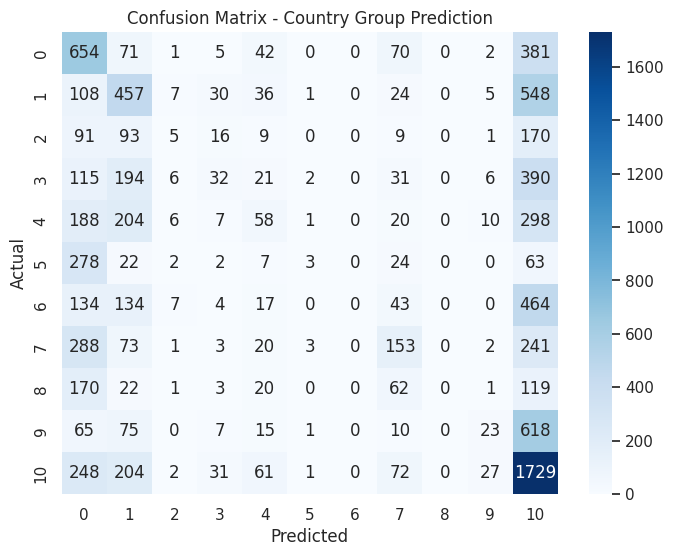

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=model_Log2.classes_,
            yticklabels=model_Log2.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Country Group Prediction')
plt.show()


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


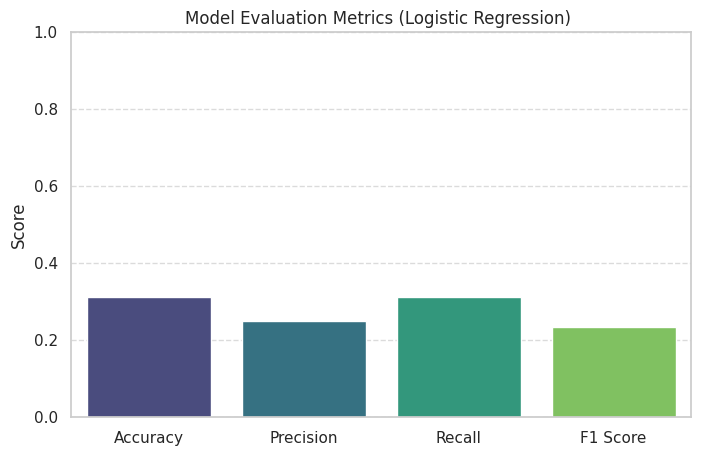

In [40]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}

import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Logistic Regression) ')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Random Forest 2

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_model2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,         
    min_samples_split=5,  
    random_state=42
)

rf_model2.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = rf_model2.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.379
Precision: 0.43074836313221215
Recall: 0.379
F1 Score: 0.3050194164759374

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.52      0.42      1226
           1       0.41      0.40      0.41      1216
           2       0.00      0.00      0.00       394
           3       0.63      0.18      0.29       797
           4       0.64      0.18      0.28       792
           5       0.62      0.01      0.02       401
           6       0.63      0.04      0.08       803
           7       0.39      0.12      0.18       784
           8       0.00      0.00      0.00       398
           9       0.56      0.13      0.20       814
          10       0.35      0.90      0.51      2375

    accuracy                           0.38     10000
   macro avg       0.42      0.23      0.22     10000
weighted avg       0.43      0.38      0.31     10000


Confusion Matrix:
[[ 642   21    0    0    7    1    2   35    0    0  5

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


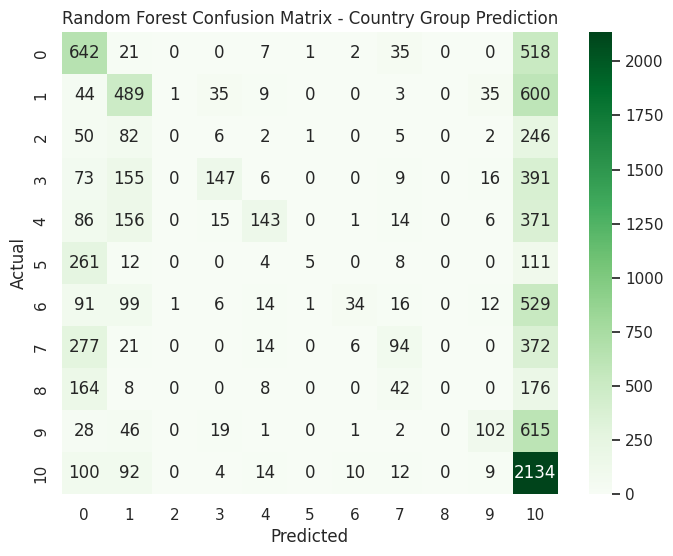

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens',
            xticklabels=rf_model2.classes_,
            yticklabels=rf_model2.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix - Country Group Prediction')
plt.show()


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


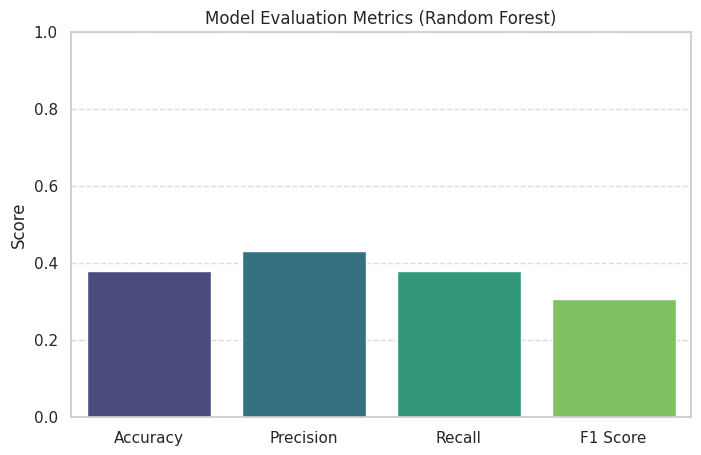

In [44]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}

import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Random Forest)')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Neural Network 2

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411 (1.61 KB)

 Trainable params: 411 (1.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1960 - loss: 2.2825 - precision: 0.4641 - recall: 0.0071 - val_accuracy: 0.3110 - val_loss: 2.0239 - val_precision: 0.5673 - val_recall: 0.0490
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3154 - loss: 2.0082 - precision: 0.5681 - recall: 0.0482 - val_accuracy: 0.3198 - val_loss: 1.9831 - val_precision: 0.5794 - val_recall: 0.0547
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3270 - loss: 1.9553 - precision: 0.6144 - recall: 0.0600 - val_accuracy: 0.3216 - val_loss: 1.9535 - val_precision: 0.6533 - val_recall: 0.0469
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3323 - loss: 1.9363 - precision: 0.6359 - recall: 0.0642 - val_accuracy: 0.3325 - val_loss: 1.9311 - val_precision: 0.6588 - val_recall: 0.0630
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3451 - loss: 1.9078 - precision: 0.6251 - recall: 0.0743 - val_accuracy: 0.3324 - va

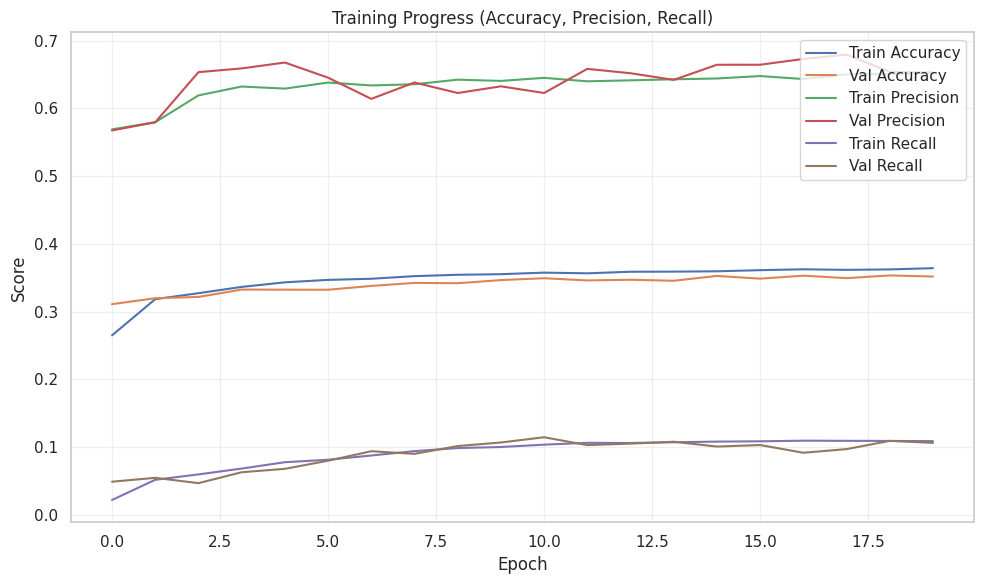

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.3507
Precision: 0.32916854032278
Recall: 0.3507
F1 Score: 0.2937540214034718

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.34      0.46      0.39      1226
           East_Asia       0.43      0.36      0.39      1216
      Eastern_Europe       0.18      0.01      0.02       394
         Middle_East       0.35      0.22      0.27       797
       North_America       0.31      0.24      0.27       792
North_America_Mexico       0.50      0.01      0.02       401
             Oceania       0.30      0.01      0.02       803
       South_America       0.23      0.21      0.22       784
          South_Asia       0.00      0.00      0.00       398
      Southeast_Asia       0.33      0.16      0.22       814
      Western_Europe       0.36      0.77      0.49      2375

            accuracy                           0.35     10000
           macro avg       0.30      0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


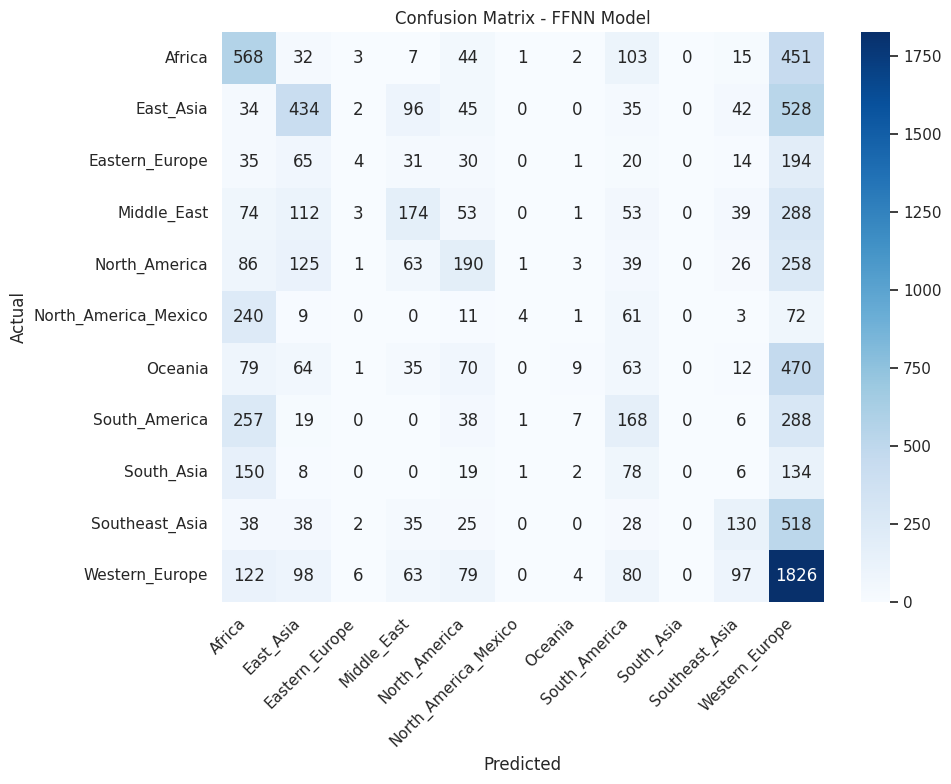

In [45]:
le = LabelEncoder()
y_encoded = le.fit_transform(df['country_group'])
y_categorical = to_categorical(y_encoded)  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_Some)

X_train_scaled1, X_test_scaled1, y_train_scaled1, y_test_scaled1 = train_test_split(
    X_scaled, y_categorical,
    test_size=0.2, random_state=42,
    stratify=y_categorical
)

model_ffnn2 = Sequential([
    Input(shape=(X_train_scaled1.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(y_categorical.shape[1], activation='softmax')  # output neurons = num of classes
])

model_ffnn2.summary()

model_ffnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history = model_ffnn2.fit(
    X_train_scaled1, y_train_scaled1,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')

plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Progress (Accuracy, Precision, Recall)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

y_pred_probs_ffnn1 = model_ffnn2.predict(X_test_scaled1)
y_pred_ffnn1 = np.argmax(y_pred_probs_ffnn1, axis=1)
y_true_ffnn1 = np.argmax(y_test_scaled1, axis=1)

# Print metrics
print("Accuracy:", accuracy_score(y_true_ffnn1, y_pred_ffnn1))
print("Precision:", precision_score(y_true_ffnn1, y_pred_ffnn1, average='weighted'))
print("Recall:", recall_score(y_true_ffnn1, y_pred_ffnn1, average='weighted'))
print("F1 Score:", f1_score(y_true_ffnn1, y_pred_ffnn1, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_true_ffnn1, y_pred_ffnn1, target_names=le.classes_))

cm = confusion_matrix(y_true_ffnn1, y_pred_ffnn1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - FFNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Comparing the models 2

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


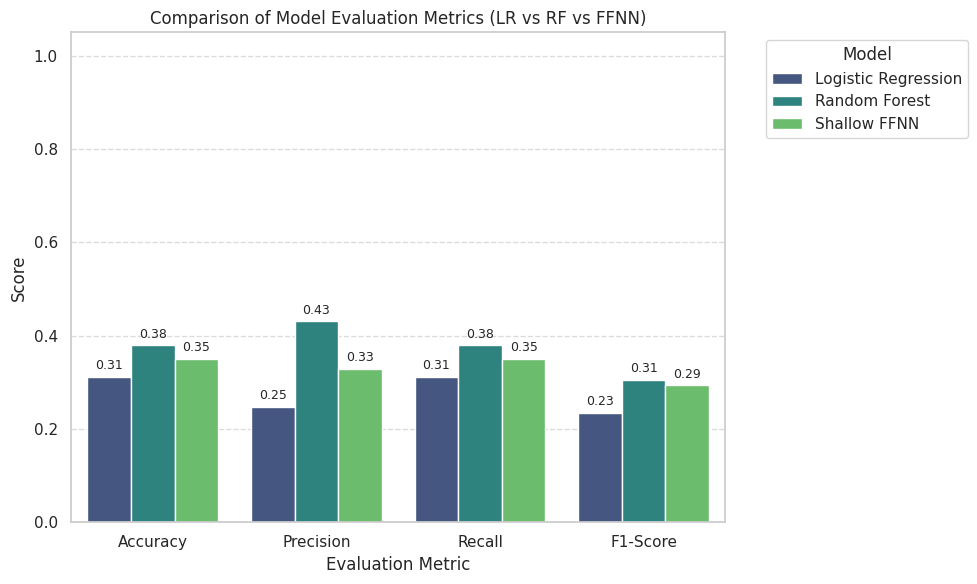


📊 Model Performance Summary:



Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.3114     0.2478  0.3114    0.2342
1        Random Forest    0.3790     0.4307  0.3790    0.3050
2         Shallow FFNN    0.3507     0.3292  0.3507    0.2938

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Logistic Regression
y_pred_lr = model_Log2.predict(X_test)

# Random Forest
y_pred_rf = rf_model2.predict(X_test)

# FFNN (deep learning model)
y_pred_probs_ffnn1 = model_ffnn2.predict(X_test_scaled1)
y_pred_ffnn1 = np.argmax(y_pred_probs_ffnn1, axis=1)
y_true_ffnn1 = np.argmax(y_test_scaled1, axis=1)


# Convert y_test to class indices if it’s one-hot encoded
if len(y_test.shape) > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test


def get_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }


results = []
results.append(get_metrics(y_test_labels, y_pred_lr, 'Logistic Regression'))
results.append(get_metrics(y_test_labels, y_pred_rf, 'Random Forest'))
results.append(get_metrics(y_true_ffnn1, y_pred_ffnn1, 'Shallow FFNN'))

# Convert to DataFrame
comparison_df = pd.DataFrame(results)
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model', palette='viridis')

# Add numeric values on top of bars
for i, bar in enumerate(plt.gca().patches):
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.2f}",
        ha='center', va='bottom', fontsize=9
    )

plt.title('Comparison of Model Evaluation Metrics (LR vs RF vs FFNN)')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("\n📊 Model Performance Summary:\n")
display(comparison_df.round(4))


In [47]:
for col in score_features:
    print(col, df.groupby('country_group')[col].nunique())

score_overall country_group
Africa                  13
East_Asia               11
Eastern_Europe          10
Middle_East             12
North_America           12
North_America_Mexico    10
Oceania                 10
South_America           11
South_Asia              10
Southeast_Asia          11
Western_Europe          11
Name: score_overall, dtype: int64
score_cleanliness country_group
Africa                  22
East_Asia               21
Eastern_Europe          20
Middle_East             21
North_America           21
North_America_Mexico    20
Oceania                 23
South_America           21
South_Asia              20
Southeast_Asia          21
Western_Europe          23
Name: score_cleanliness, dtype: int64
score_comfort country_group
Africa                  21
East_Asia               19
Eastern_Europe          17
Middle_East             19
North_America           20
North_America_Mexico    17
Oceania                 18
South_America           18
South_Asia              17
Sou

# Features including location_base


After detecting data leakage from multiple hotel baseline columns, we refined the feature set to include only location_base, as it had the strongest correlation with (country_group) without fully encoding geographic identity.

This approach allows the model to leverage meaningful location-related information, since location quality naturally differs across regions, while minimizing leakage from hotel-specific features.

By retaining only location_base, we improved model accuracy and F1-score while ensuring predictions remained driven by behavioral and perceptual differences rather than memorized country-specific hotel patterns, achieving a balance between performance and fair generalization.

In [84]:

score_features = [
    'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'location_base', 
]

user_features = ['age_group', 'traveller_type', 'user_gender']



X = df[score_features + user_features]

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y)

After experimenting with multiple models in the previous trainings, Random Forest Classifier consistently achieved the highest performance metrics across accuracy, precision, recall, and F1-score.

Overall, Random Forest offered the best balance between predictive performance, robustness, and interpretability, making it the optimal model for the final country group classification task.

In [86]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,          # limit depth
    min_samples_split=5,   # minimum samples per split
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7253
Precision: 0.7463679384077141
Recall: 0.7253
F1 Score: 0.720409650936623

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1226
           1       0.82      0.63      0.71      1216
           2       0.52      0.44      0.48       394
           3       0.82      0.67      0.74       797
           4       0.86      0.84      0.85       792
           5       0.61      0.64      0.62       401
           6       0.66      0.64      0.65       803
           7       0.59      0.54      0.56       784
           8       1.00      0.72      0.84       398
           9       0.92      0.47      0.62       814
          10       0.65      0.94      0.77      2375

    accuracy                           0.73     10000
   macro avg       0.75      0.67      0.70     10000
weighted avg       0.75      0.73      0.72     10000


Confusion Matrix:
[[1016   21    0    2   40    0    0   50    0    0   

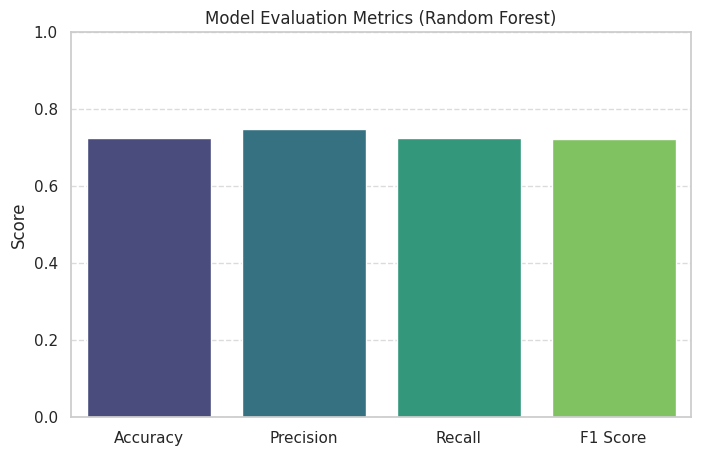

In [52]:
# --- Store metrics in a dictionary ---
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}


import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Random Forest)')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# SHAP and LIME

SHAP explains both global and local feature importance:

The global summary plots show how each feature influences predictions across all country groups.

The local force plots illustrate how individual feature values push predictions toward specific regions relative to the model’s baseline.

LIME complements this by providing instance-level explanations, identifying which features most affected a single prediction.

Together, SHAP and LIME confirm that features like location_base and score_location were key drivers in predicting the hotel’s country group, enhancing transparency and model trust.

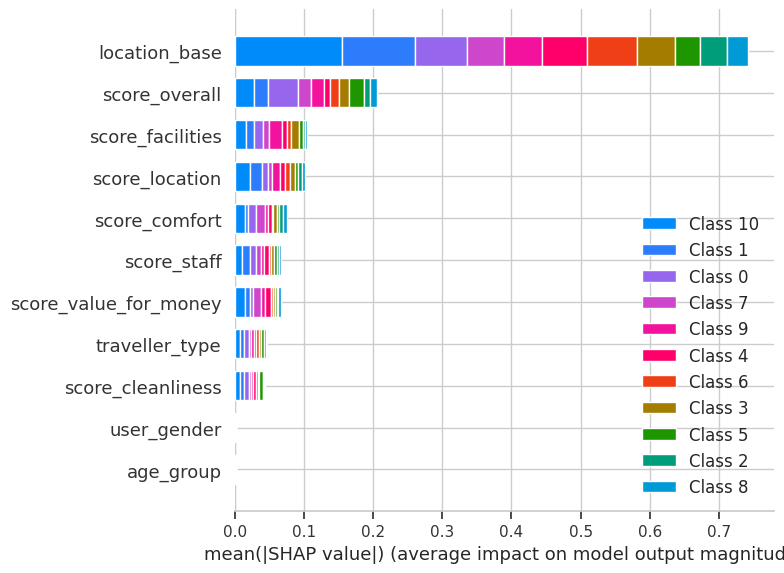

In [53]:
# --- SHAP Global Explanation for Random Forest --- 
explainer = shap.TreeExplainer(rf_model) 
shap_values = explainer.shap_values(X_test) 

# Global SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


 Global SHAP summary for Africa:


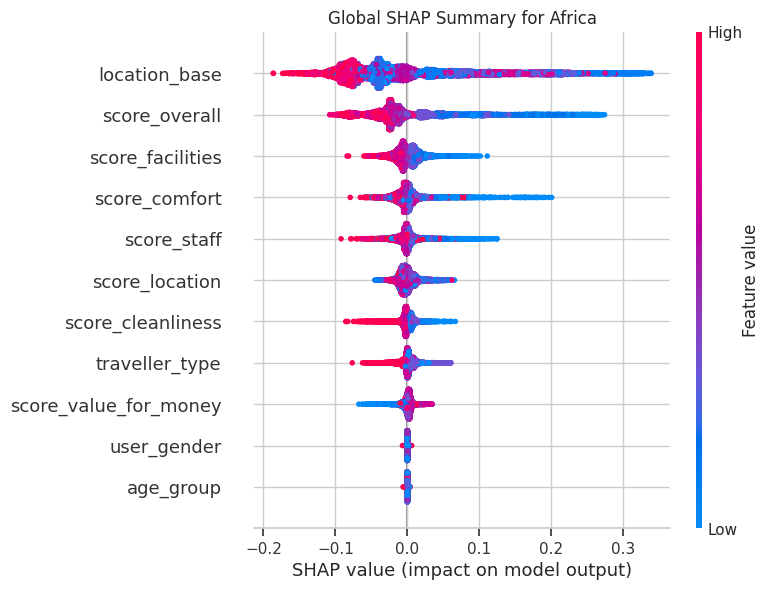


 Global SHAP summary for East_Asia:


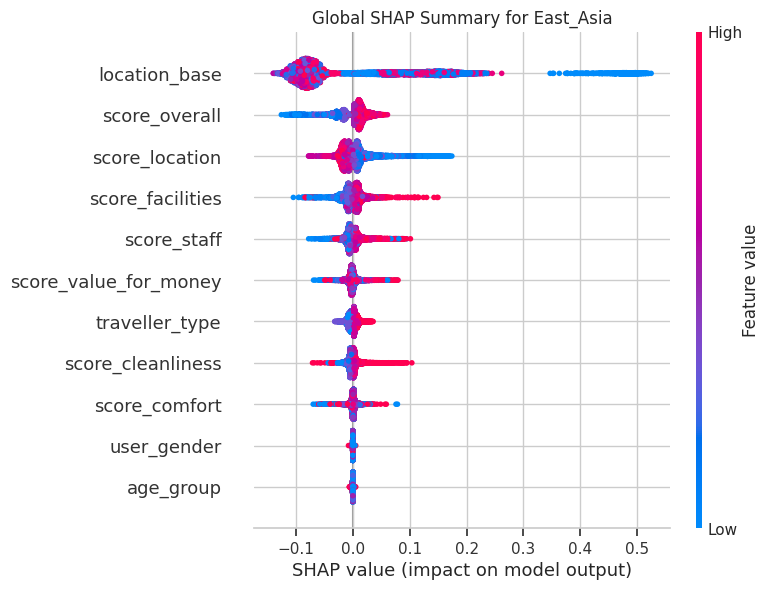


 Global SHAP summary for Eastern_Europe:


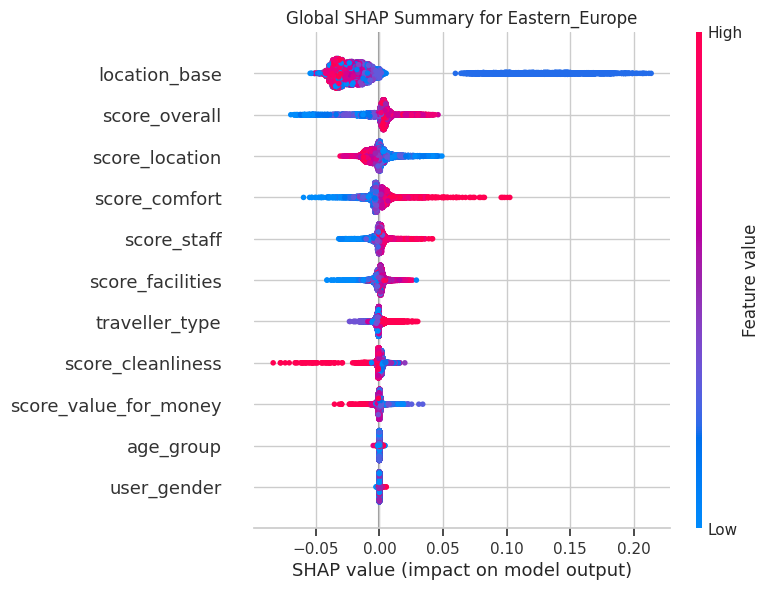


 Global SHAP summary for Middle_East:


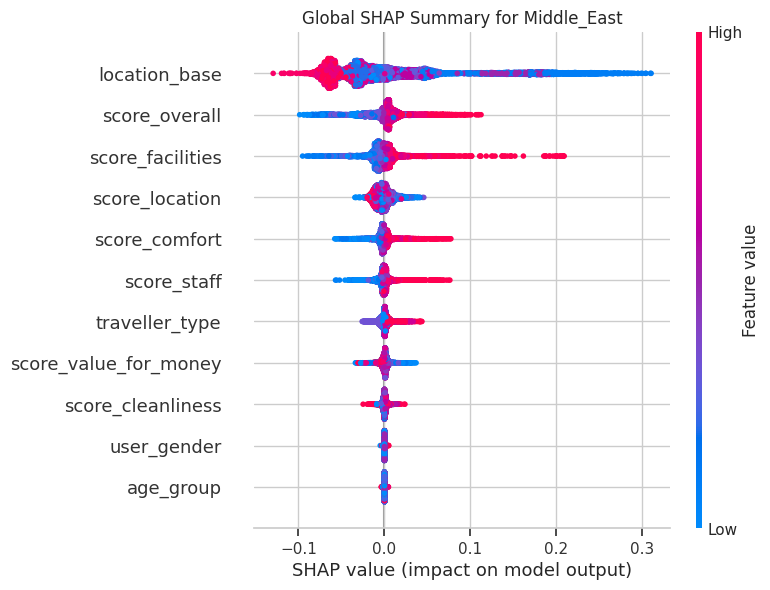


 Global SHAP summary for North_America:


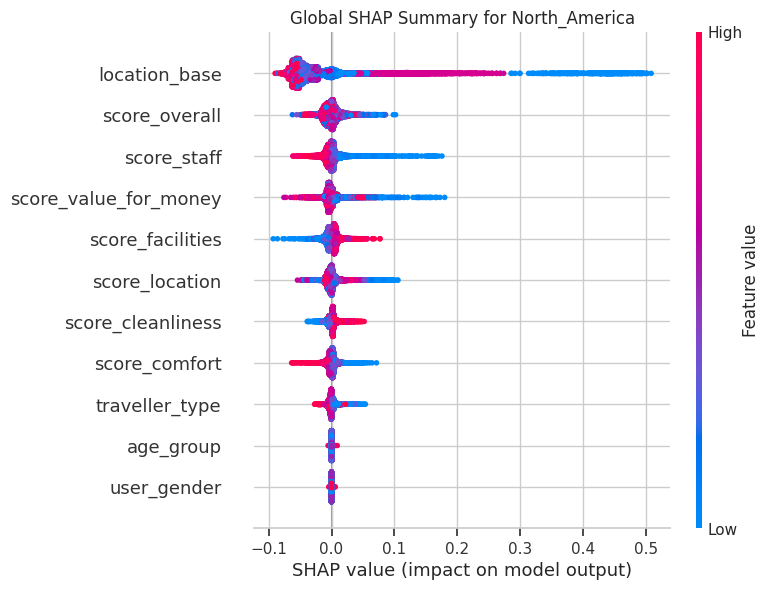


 Global SHAP summary for North_America_Mexico:


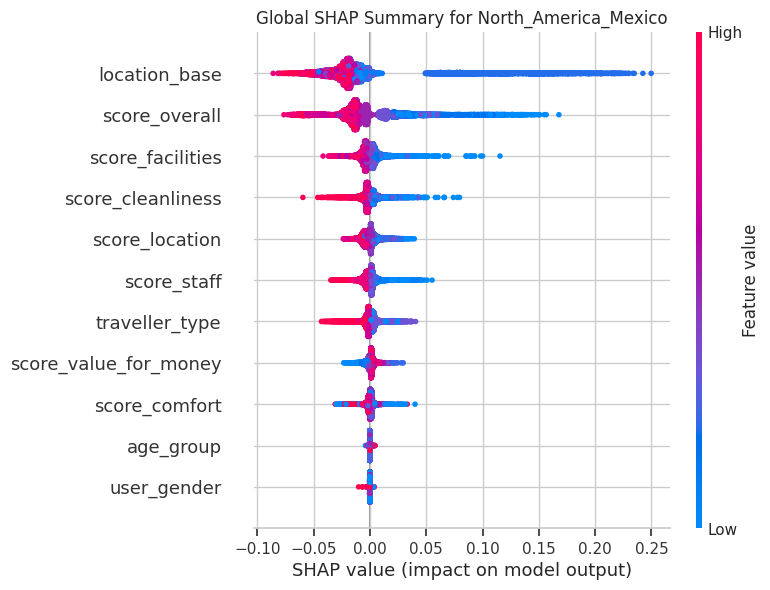


 Global SHAP summary for Oceania:


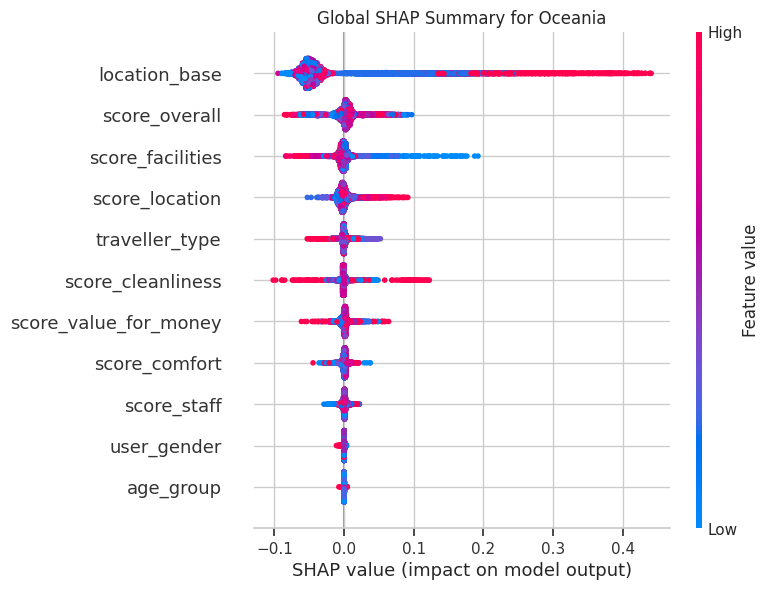


 Global SHAP summary for South_America:


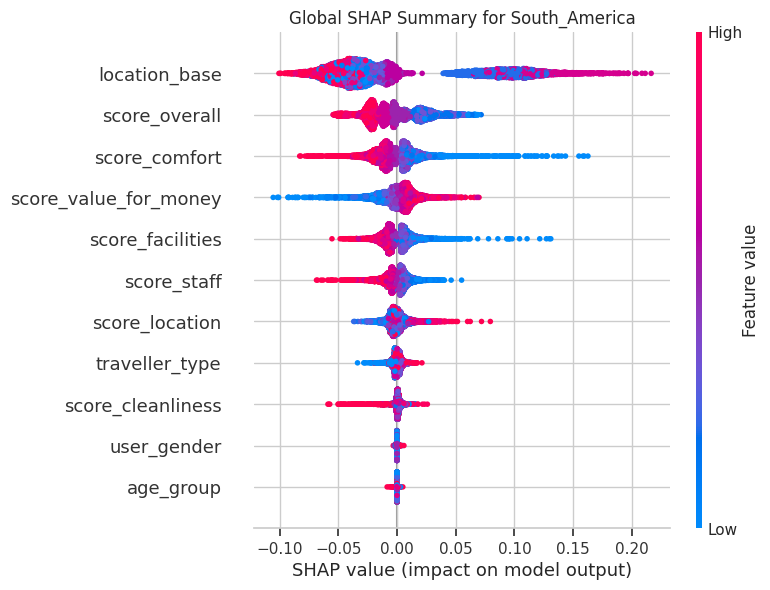


 Global SHAP summary for South_Asia:


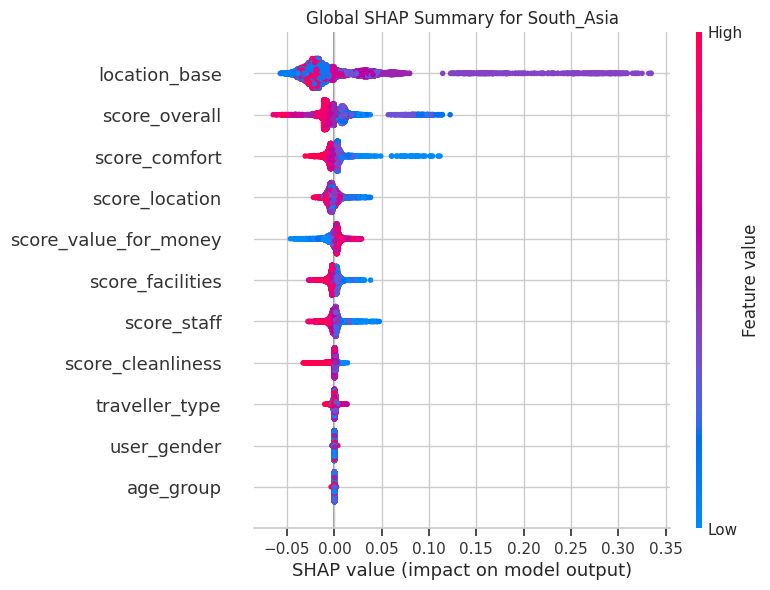


 Global SHAP summary for Southeast_Asia:


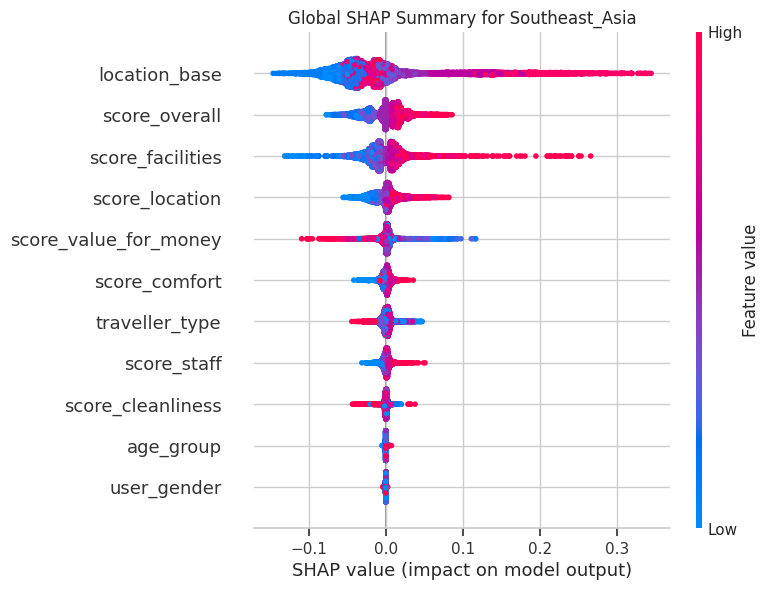


 Global SHAP summary for Western_Europe:


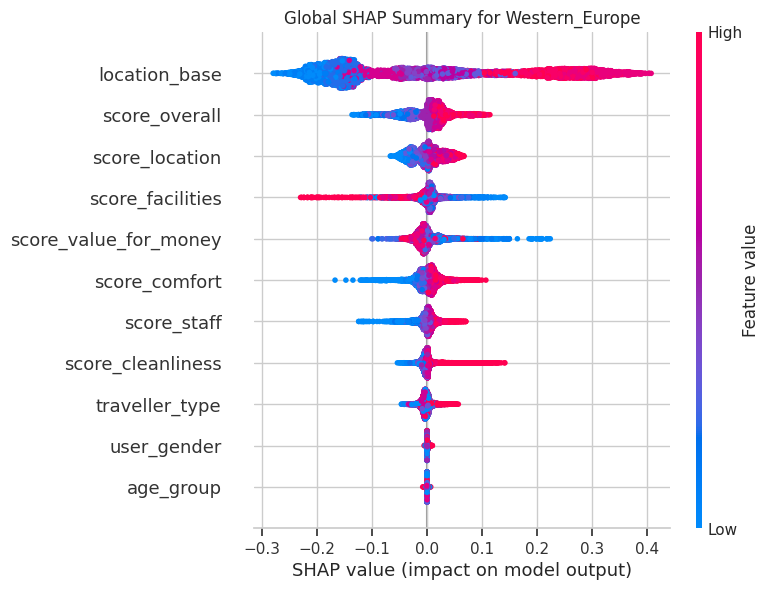

In [54]:
label_mapping = {
    'Africa': 0,
    'East_Asia': 1,
    'Eastern_Europe': 2,
    'Middle_East': 3,
    'North_America': 4,
    'North_America_Mexico': 5,
    'Oceania': 6,
    'South_America': 7,
    'South_Asia': 8,
    'Southeast_Asia': 9,
    'Western_Europe': 10
}


# Invert mapping: number → country name
class_names = {v: k for k, v in label_mapping.items()}

# --- Compute SHAP values ---
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# --- Global SHAP summary plot for multi-class ---
for i, class_name in class_names.items():
    print(f"\n Global SHAP summary for {class_name}:")
    shap.summary_plot(shap_values[i], X_test, feature_names=X_test.columns, show=False)
    plt.title(f"Global SHAP Summary for {class_name}")
    plt.show()


In [55]:
import shap
shap.initjs()

i = 0 

if isinstance(shap_values, list):
    shap_values_instance = shap_values[0][i]
    expected_value = explainer.expected_value[0]
else:
    shap_values_instance = shap_values[i]
    expected_value = explainer.expected_value

feature_names = X_test.columns[:len(shap_values_instance)]

shap.force_plot(
    expected_value,
    shap_values_instance,
    X_test.iloc[i, :len(shap_values_instance)],
    feature_names=feature_names
)


In [77]:
# Initialize the LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=list(set(y)),   
    discretize_continuous=True
)


i = 5 
exp = explainer_lime.explain_instance(
    X_test.values[i],
    rf_model.predict_proba,  
    num_features=11
)

# Show explanation
exp.show_in_notebook()


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


# Inference Function

The inference function replicates the same preprocessing pipeline used during training to ensure consistent model behavior. It takes a new raw input (user and hotel review details), encodes categorical features (age_group, traveller_type, and user_gender) using the same mappings, and converts the data into a properly ordered DataFrame.

The trained Random Forest model then predicts both the most likely country group and its associated probabilities across all possible classes. Finally, the numeric prediction is decoded back into its original label.

This setup ensures that the model can generalize and make accurate, interpretable predictions on unseen data while maintaining full consistency with the training process.

In [88]:
# Define the same mappings used during training
age_group_mapping = {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55+': 4}
traveller_type_mapping = {'Solo': 0, 'Family': 1, 'Couple': 2, 'Business': 3}
gender_mapping = {'Male': 0, 'Female': 1, 'Other': 2}  # you used 'Other', not 'Others'

def predict_country_group(model, raw_input, label_encoder):
    """
    Takes raw input (scores + user info), applies the same encoding
    as training, predicts, and returns the decoded label.
    """

    # --- Encode categorical features based on training mappings ---
    encoded_input = {
        'score_overall': raw_input['score_overall'],
        'score_cleanliness': raw_input['score_cleanliness'],
        'score_comfort': raw_input['score_comfort'],
        'score_facilities': raw_input['score_facilities'],
        'score_location': raw_input['score_location'],
        'score_staff': raw_input['score_staff'],
        'score_value_for_money': raw_input['score_value_for_money'],
        'location_base': raw_input['location_base'],
        'age_group': age_group_mapping.get(raw_input['age_group'], -1),
        'traveller_type': traveller_type_mapping.get(raw_input['traveller_type'], -1),
        'user_gender': gender_mapping.get(raw_input['user_gender'], -1)
    }


    X_new = pd.DataFrame([encoded_input])


    pred_encoded = model.predict(X_new)[0]
    pred_proba = model.predict_proba(X_new)[0]

    # --- Decode numeric label back to country group ---
    pred_country = label_encoder.inverse_transform([pred_encoded])[0]

    # --- Print top probable groups 
    top3 = sorted(
        zip(label_encoder.classes_, pred_proba),
        key=lambda x: x[1],
        reverse=True
    )[:3]

    print(f" Predicted Country Group: {pred_country}")
    print("\nTop 3 most likely groups:")
    for c, p in top3:
        print(f"{c}: {p:.3f}")

    return pred_country


# Examples and Sample Input for Inference Function 

In [89]:

sample_input = {
    'score_overall': 9.2,
    'score_cleanliness': 8.9,
    'score_comfort': 9.0,
    'score_facilities': 8.8,
    'score_location': 9.3,
    'score_staff': 9.1,
    'score_value_for_money': 8.5,
    'location_base': 8.9,
    'age_group': '25-34',
    'traveller_type': 'Couple',
    'user_gender': 'Female'
}

# Run inference
predict_country_group(rf_model, sample_input, le)


 Predicted Country Group: Middle_East

Top 3 most likely groups:
Middle_East: 0.319
East_Asia: 0.293
North_America: 0.073


'Middle_East'

In [90]:
sample_input_business = {
    'score_overall': 9.0,
    'score_cleanliness': 9.2,
    'score_comfort': 9.5,
    'score_facilities': 9.3,
    'score_location': 9.7,
    'score_staff': 9.0,
    'score_value_for_money': 8.4,
    'location_base': 9.6,
    'age_group': '35-44',
    'traveller_type': 'Business',
    'user_gender': 'Male'
}

predict_country_group(rf_model, sample_input_business, le)


 Predicted Country Group: Western_Europe

Top 3 most likely groups:
Western_Europe: 0.590
East_Asia: 0.279
Southeast_Asia: 0.068


'Western_Europe'

In [91]:
sample_input_family = {
    'score_overall': 8.2,
    'score_cleanliness': 8.0,
    'score_comfort': 8.3,
    'score_facilities': 8.1,
    'score_location': 8.5,
    'score_staff': 8.4,
    'score_value_for_money': 8.7,
    'location_base': 8.2,
    'age_group': '45-54',
    'traveller_type': 'Family',
    'user_gender': 'Female'
}
predict_country_group(rf_model, sample_input_family, le)

 Predicted Country Group: Africa

Top 3 most likely groups:
Africa: 0.450
East_Asia: 0.372
North_America: 0.131


'Africa'

In [92]:
sample_input = {
    'score_overall': 8.4,
    'score_cleanliness': 9.2,
    'score_comfort': 9.0,
    'score_facilities': 8.5,
    'score_location': 6.2,
    'score_staff': 8.9,
    'score_value_for_money': 8.4,
    'location_base': 6.5,
    'age_group': '25-34',
    'traveller_type': 'Family',
    'user_gender': 'Female'
}
predict_country_group(rf_model, sample_input, le)

 Predicted Country Group: East_Asia

Top 3 most likely groups:
East_Asia: 0.573
Africa: 0.310
North_America: 0.051


'East_Asia'

# Feature Set including a mix of Hotel-Based Features other than location_base

In [93]:
# --- Step 1: Define columns ---
score_features = [
   'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'comfort_base', 
    'staff_base', 
    'value_for_money_base'
]

user_features = ['age_group', 'traveller_type', 'user_gender']


# --- Step 2: Split the data ---
X1 = df[score_features + user_features]

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X1, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [95]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,         
    min_samples_split=5,   
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1226
           1       1.00      1.00      1.00      1216
           2       1.00      1.00      1.00       394
           3       1.00      1.00      1.00       797
           4       1.00      1.00      1.00       792
           5       1.00      1.00      1.00       401
           6       1.00      1.00      1.00       803
           7       1.00      1.00      1.00       784
           8       1.00      1.00      1.00       398
           9       1.00      1.00      1.00       814
          10       1.00      1.00      1.00      2375

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


Confusion Matrix:
[[1226    0    0    0    0    0    0    0    0    0    0]
 [   0 1216    0    0    0    0

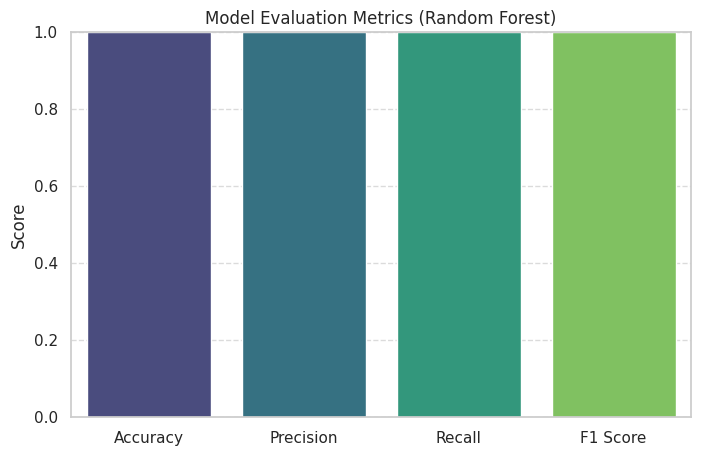

In [97]:

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}


import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Random Forest)')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Feature Set Including staff_based

In [98]:

score_features = [
   'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'staff_base', 
]

user_features = ['age_group', 'traveller_type', 'user_gender']



X2 = df[score_features + user_features]

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X2, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [100]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,         
    min_samples_split=5,   
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6677
Precision: 0.7281890811179651
Recall: 0.6677
F1 Score: 0.6381431782637692

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1226
           1       0.95      0.61      0.74      1216
           2       0.62      0.08      0.14       394
           3       0.87      0.88      0.88       797
           4       0.86      0.70      0.77       792
           5       0.77      0.33      0.46       401
           6       0.73      0.37      0.49       803
           7       0.66      1.00      0.80       784
           8       1.00      0.00      0.01       398
           9       0.75      0.54      0.63       814
          10       0.52      0.94      0.67      2375

    accuracy                           0.67     10000
   macro avg       0.77      0.55      0.57     10000
weighted avg       0.73      0.67      0.64     10000


Confusion Matrix:
[[ 765    0    0    0   59   39    0    0    0    0  

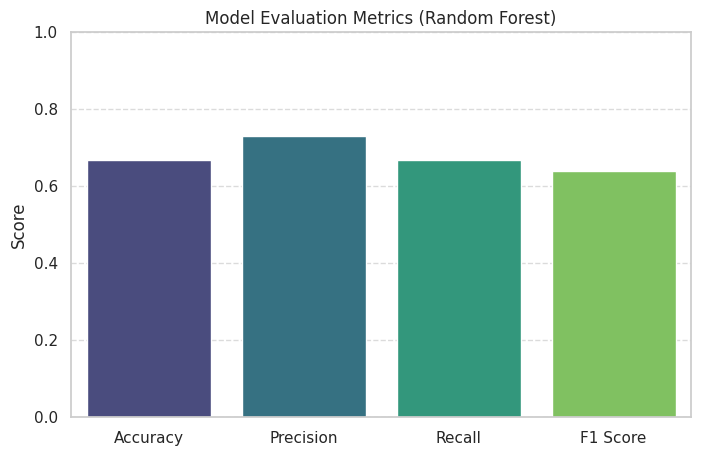

In [102]:
# --- Store metrics in a dictionary ---
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}

# --- Convert to DataFrame for plotting ---
import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Random Forest)')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Feature Set using facilities_based (least correlation with country_group)

In [103]:

score_features = [
   'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'facilities_base', 
]

user_features = ['age_group', 'traveller_type', 'user_gender']



X3 = df[score_features + user_features]

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X3, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [105]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,          
    min_samples_split=5,   
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6942
Precision: 0.716431721103037
Recall: 0.6942
F1 Score: 0.6683180126467895

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      1226
           1       0.65      0.94      0.77      1216
           2       0.81      0.15      0.25       394
           3       0.95      0.66      0.78       797
           4       0.94      0.54      0.68       792
           5       0.60      0.29      0.39       401
           6       0.78      0.45      0.57       803
           7       0.63      0.70      0.66       784
           8       0.52      0.13      0.20       398
           9       0.84      0.79      0.81       814
          10       0.65      0.98      0.78      2375

    accuracy                           0.69     10000
   macro avg       0.73      0.57      0.59     10000
weighted avg       0.72      0.69      0.67     10000


Confusion Matrix:
[[ 748    0    0   18    0   37   25   73    0    0  3

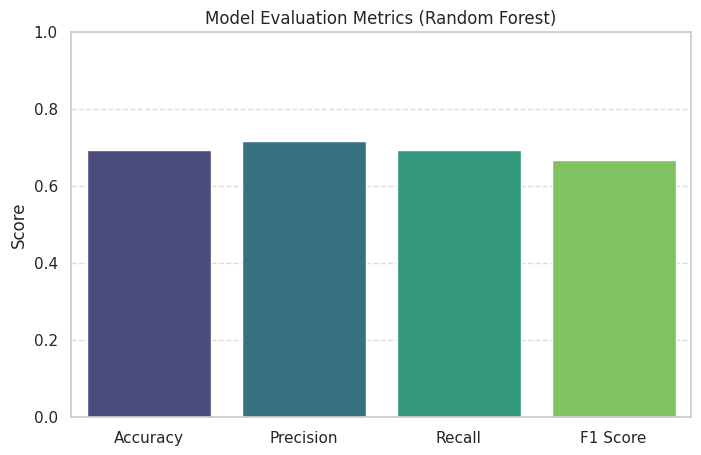

In [76]:
# --- Store metrics in a dictionary ---
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}


import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])


plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Random Forest)')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
